# scRNASeq analysis with Seurat and other tools

## Seurat install

The Seurat package will need to be installed. You can find further instructions for install found [here](https://satijalab.org/seurat/install.html). It is installed via a separate package manager (in R) Bioconductor and R's package manager CRAN.

In [1]:
# Check if Bioconductor is installed. If not, install
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
# Install a necessary package for Seurat
BiocManager::install('multtest')
BiocManager::install('MAST')
# Install Seurat
install.packages('Seurat')

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Bioconductor version 3.10 (BiocManager 1.30.10), R 3.6.2 (2019-12-12)

Installing package(s) 'BiocVersion', 'multtest'

also installing the dependencies 'BiocGenerics', 'Biobase'


Warning message in install.packages(...):
"installation of package 'Biobase' had non-zero exit status"
Warning message in install.packages(...):
"installation of package 'multtest' had non-zero exit status"
Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Old packages: 'KernSmooth', 'MASS', 'Rcpp', 'SQUAREM', 'backports', 'boot',
  'broom', 'callr', 'class', 'dbplyr', 'dplyr', 'ellipsis', 'foreach', 'fs',
  'ggplot2', 'glmnet', 'glue', 'gower', 'haven', 'htmltools', 'httpuv',
  'jsonlite', 'knitr', 'later', 'lattice', 'lubridate', 'modelr', 'nlme',
  'nnet', 'openssl', 'pillar', 'promises', 'ps', 'purrr', 'quantmod', 'rbokeh',
  'recipes', 'reshape2', 'rlang', 'rmarkdown', 'scales', 'shiny', 'spat

## Setup of the scRNASeq data into a Seurat object

For this first part of the tutorial, we will be analyzing a small dataset of peripheral blood mononuclear cells (PBMC) provided by 10X Genomics. This is a data set of 2,700 single cells sequenced on Illumina NextSeq 500. You can get the raw data [here](https://s3-us-west-2.amazonaws.com/10x.files/samples/cell/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz).

When starting your RStudio session, please move to a separate folder for this project. I will assume you named it **seurat_tutorial**. Then please make a folder named **data** in the **seurat_tutorial** folder and place the downloaded 10X data in the **data** folder. It should be named **pbmc3k_filtered_gene_bc_matrices.tar.gz**. The file will need to be untarred.
* On Windows, the free and open source program 7zip can be used to decompress this file
* On Mac (and Linux), you should be able to decompress this in Finder in the GUI by default.

In [2]:
setwd("~/")

*Note that* `setwd` *stands for set working directory.*

Now that the environment is set up, we can start by loading the raw data into Seurat so that it is formatted to work with the rest of the Seurat toolset.

In [1]:
# Load the libraries

# Library for multtest; unneeded as Seurat should automatically load it
library(multtest)

# Library for Seurat, the scRNASeq analysis toolkit
library(Seurat)

# Library for MAST, the differential gene analysis algorithm for
# scRNASeq. Needs to be loaded to work in Seurat
library(MAST)

# Library for plotting in R
library(ggplot2)

# Library for making heatmaps with Seurat
library(patchwork)

# Library Seurat uses on top of ggplot
# to plot things easily onto a grid
library(cowplot)


Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Loading required package: Biobase

Welcome to Bioconductor

    Vignettes contain introductory material; vie

ERROR: Error in library(ggplot): there is no package called ‘ggplot’


In [2]:
# Load the PBMC dataset
pbmc.data <- Read10X(data.dir = "./data/pbmc3k_filtered_gene_bc_matrices/filtered_gene_bc_matrices/hg19")
# Initialize the Seurat object with the raw (non-normalized data).
# counts       : your loaded count data
# project      : the name of this object
# min.cells    : assumed lower threshold for cells
# min.features : assumed lower threhold for genes
pbmc <- CreateSeuratObject(
    counts = pbmc.data,
    project = "pbmc3k",
    min.cells = 3,
    min.features = 200
)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


The data for the PBMC scRNASeq is split between three files:
* barcodes.tsv
* genes.tsv
* matrix.mtx

The three combined work together to define a count matrix. Seurat then converts the data into a single object representing the count matrix. Now that the data has been loaded into a Seurat object, what does the data look like.

In [3]:
# Lets examine a few genes in the first thirty cells
pbmc.data[c("CD3D", "TCL1A", "MS4A1"), 1:30]

   [[ suppressing 30 column names ‘AAACATACAACCAC’, ‘AAACATTGAGCTAC’, ‘AAACATTGATCAGC’ ... ]]



3 x 30 sparse Matrix of class "dgCMatrix"
                                                                   
CD3D  4 . 10 . . 1 2 3 1 . . 2 7 1 . . 1 3 . 2  3 . . . . . 3 4 1 5
TCL1A . .  . . . . . . 1 . . . . . . . . . . .  . 1 . . . . . . . .
MS4A1 . 6  . . . . . . 1 1 1 . . . . . . . . . 36 1 2 . . 2 . . . .

The `.` values represent 0s (or no molecules detected). scRNASeq is naturally sparse - i.e. we expect to see a lot of 0 values. This has major effects on the type of analyses we can perform on the data, which is what scRNASeq analyses attempt to deal with.

Additionally, we should become familiar with the meta data features of a Seurat object. The meta data are annotations applied to each cell. We can view them with:

In [5]:
head(pbmc@meta.data)

orig.ident nCount_RNA nFeature_RNA
AAACATACAACCAC pbmc3k     2419        779        
AAACATTGAGCTAC pbmc3k     4903       1352        
AAACATTGATCAGC pbmc3k     3147       1129        
AAACCGTGCTTCCG pbmc3k     2639        960        
AAACCGTGTATGCG pbmc3k      980        521        
AAACGCACTGGTAC pbmc3k     2163        781

These are the default annotations in the Seurat object. We can see we've labeled every cell with the project `pbmc3k`. Additionally, the total number of RNA molecules sequenced for that cell and the total number of genes (a.k.a features) detected within the cell.

The real utility comes from adding annotations to these cells. Let us add our cell type annotations from scMatch.

In [10]:
# First read the file in as a data frame with R's built in
# read.csv() function.
pbmc.scmatch <- read.csv(
    "./data/pbmc3k_filtered_gene_bc_matrices/pbmc1k_scmatch.csv",
    row.names = 1
)
# Now we must rename the cells, as scMatch adds a '-1' to each cell ID
# We reassign all rownames of the pbmc3k.scmatch data frame (via row.names())
# and by sending it the new list.
# The new list is composed of sub(), which replaces all instances of "-1" 
# with nothing for all rownames
# Note that row.names() is different than rownames() and works in a subtlely 
# different manner. For our purposes here, they work exactly the same.
row.names(pbmc.scmatch) <- sub("-1", "", rownames(pbmc.scmatch))

The makeup of the scmatch data looks as so:

In [12]:
head(pbmc.scmatch)

cell.type         
AAACATACAACCAC CD8+ T cell       
AAACATTGAGCTAC B cell            
AAACATTGATCAGC CD4+ T cell       
AAACCGTGCTTCCG monocyte          
AAACCGTGTATGCG gamma-delta T cell
AAACGCACTGGTAC CD4+ T cell       
               top.sample                                                                
AAACATACAACCAC CD8+ T Cells (pluriselect), donor090309, donation3.CNhs12180.12196-129B9  
AAACATTGAGCTAC CD19+ B Cells (pluriselect), donor090309, donation2.CNhs12179.12194-129B7 
AAACATTGATCAGC CD4+CD25-CD45RA- memory conventional T cells, donor2.CNhs13237.11798-124C7
AAACCGTGCTTCCG CD14-CD16+ Monocytes, donor1.CNhs13229.11790-124B8                        
AAACCGTGTATGCG gamma delta positive T cells, donor1.CNhs13914.11937-126A2                
AAACGCACTGGTAC CD4+CD25+CD45RA- memory regulatory T cells, donor2.CNhs13206.11797-124C6  
               top.correlation.score
AAACATACAACCAC 0.2694394            
AAACATTGAGCTAC 0.3398503            
AAACATTGATCAGC 0.3238483            
AAACCGTGCTTCCG 0.3081723            
AAACCGTGTATGCG 0.2184953            
AAACGCACTGGTAC 0.2730377

What is required to add any annotations to the Seurat object is that we have some reference to the cell IDs. This scmatch dataframe contains the information for the cell IDs as the rownames. When we have this information, we can add the annotations to the Seurat object as metadata.

In [13]:
# Now we add these annotations to the Seurat object
# The subset function used here only select the column in the scMatch
# dataset that we want to add. We can add multiple columns if we so wish.
pbmc <- AddMetaData(
    object = pbmc,
    metadata = subset(pbmc.scmatch, select = c("cell.type")),
    col.name = "scmatch_celltype"
)

Now let us look at what it has added to the metadata feature.

In [14]:
head(pbmc@meta.data)

orig.ident nCount_RNA nFeature_RNA scmatch_celltype  
AAACATACAACCAC pbmc3k     2419        779         CD8+ T cell       
AAACATTGAGCTAC pbmc3k     4903       1352         B cell            
AAACATTGATCAGC pbmc3k     3147       1129         CD4+ T cell       
AAACCGTGCTTCCG pbmc3k     2639        960         monocyte          
AAACCGTGTATGCG pbmc3k      980        521         gamma-delta T cell
AAACGCACTGGTAC pbmc3k     2163        781         CD4+ T cell

We have annotated cells with the cell typing predictions from scMatch. If a cell was in the scMatch data, but not in the Seurat object, the subset invoked in the AddMetaData() function would remove those scMatch cells. In the reverse scenario where Seurat has cells that the scMatch data does not have, cells would be annotated with a null value (i.e. N/A).

## Quality control visualization

We will now perform some basic visualization of QC.

First, we will look at the overall distribution of:
* number of genes detected per cell
* number of total molecules detected per cell
* the percent of mitochonrial genes detected of total genes detected per cell

We want to look at the mitochondrial genes because low-quality or dying cells tend to exhibit extensive mitchondrial contamination. So this needs to be treated as a variable to consider when normalizing the data (by a linear regression) later.

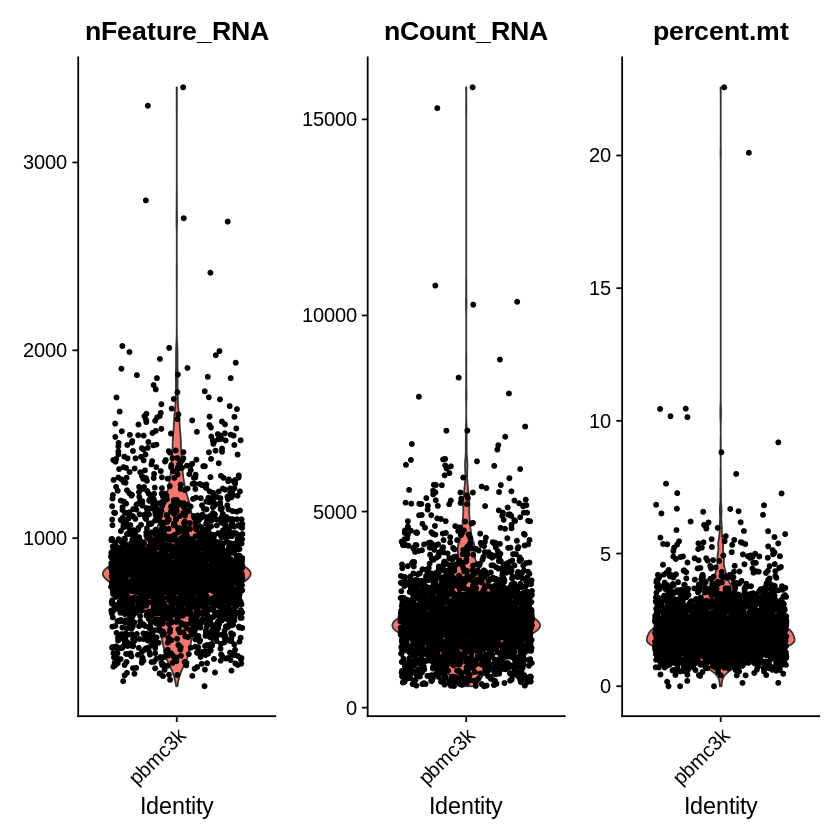

In [16]:
# Store the mitochondrial percentage into the Seurat object as meta data
# Here, we overwrite pbmc with the returned Seurat object from PercentageFeatureSet
# object   : Seurat object
# pattern  : regular expression pattern to match genes / features to
#            In this case, we look for genes prepended with MT-
#            '^' means only consider if the following characters are at the beginning
# col.name : Name of the new meta data to add to the Seurat object
# Note: In mouse datasets, the mitochondrial genes are listed by "mt-" instead.
#       This is important because the pattern is case sensitive.
pbmc <- PercentageFeatureSet(
    object = pbmc, 
    pattern = "^MT-", 
    col.name = "percent.mt"
)

# Visualize QC metrics as a violin plot
# object : Seurat object
# features : features in Seurat object to display
#            nFeature_RNA = # of genes detected in each cell
#            nCount_RNA   = # of total molecules detected in each cell
#            percent.mt   = percentage of detected genes that are mitochondrial
# ncol : # of columns to split the plots across
VlnPlot(
    object = pbmc, 
    features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), 
    ncol = 3)

Furthermore, it is good to visualize the relationship between these features. *Note that the Pearson correlation (r value) is shown as the title for each plot.*

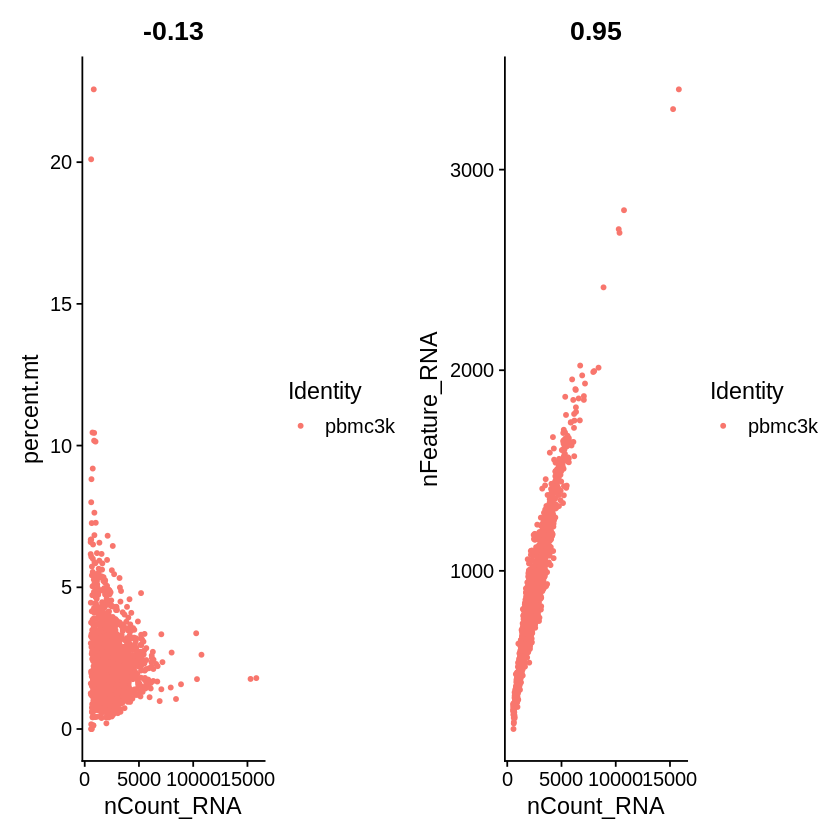

In [19]:
# FeatureScatter is typically used to visualize feature-feature relationships, but can be used
# for anything calculated by the object, i.e. columns in object metadata, PC scores etc.

plot1 <- FeatureScatter(
    pbmc, 
    feature1 = "nCount_RNA", 
    feature2 = "percent.mt"
)
plot2 <- FeatureScatter(
    pbmc, 
    feature1 = "nCount_RNA", 
    feature2 = "nFeature_RNA"
)
plot1 + plot2

## Pre-processing workflow

By default, we are going to use sctransform. This replaces Seurat's previous normalization method.
* The transformed data is stored in the Seurat object under the SCT assay
    * This becomes the default data matrix for Seurat to use for further analysis: PCA, UMAP, etc.
* During the normalization, it is important to remove confounding sources of variation. In the typical human case, this is the mitochondrial mapping percentage
    * Low-quality or dying cells tend to exhibit extensive mitchondrial contamination. So this needs to be treated as a variable to consider when normalizing the data (by a linear regression).
    
Outside of mitochondrial mapping percentage, there are a few other variables that can be included in the normalization. These have more importance in the non-sctransform normalization method shows later.
* The number of unique genes detected in each cell
    * Low-quality cells or empty droplets will often have very few genes
    * Cell doublets or multiplets may exhibit an aberrantly high gene count
* It is possible to include the total RNA sequencing to adjust normalization so that total RNA is considered as a regressor.

In [20]:
# run sctransform
# object          : Seurat object
# vars.to.regress : variables to regress out
# verbose         : printing messages and progress bars
pbmc <- SCTransform(
    object = pbmc, 
    vars.to.regress = "percent.mt",
    verbose = FALSE
)

Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in sqrt(1/i):
“NaNs produced”
Warnin

Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):
“iteration limit reached”
Warning message in theta.ml(y = y, mu = fit$fitted):

### The alternative normalization method

It is no longer recommended to perform the older normalization method. It scales all the data to the same range, removing the effect of total cell RNA. scTransform preserves the information by the total cell RNA. However in the case that sctransform is not working or you have deliberate reason to want to use this normalization method, here is how perform the following.

** *Please do not actually run the following during this workshop.* **

#### Filtration of data

From the above visuablized QC metrics, we will use these to filter cells.
* We filter cells that have unique feature counts over 2,500 or less than 200
* We filter cells that have >5% mitochondrial counts

These are typical filters to apply for most scRNASeq purposes, but there may be other concerns with your specific library that you may want to further filter on.

In [8]:
# Filter out the cells that fulfill any of the features
pbmc <- subset(
    pbmc, 
    subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5
)

#### Data normalization

Next, we normalize the data on the passing cells. By default, the process is to employ a global-scaling normalization method "LogNormalize." This normalized the gene expression measurements for each cell by the total expression, and multiplies this by a scale factor (10,000 by default) so that data is in a reasonably sized value. This is important to avoid floating point errors when dealing with very small numbers. Then the results are log transformed. The normalized data is stored in the Seurat object under 'data': `pbmc[["RNA"]]@data`.

The result of LogNormalize is that all genes are reported as a proportion expression of total expression. This way, samples and cells can be compared directly without concern for variance in library size, etc.

The other options for normalization available are:
* LogNormalize : Gene counts for each cell are divided by the total counts, and multiplied by scale.factor. Then finally log-transformed with *e* (natural number)
* CLR: Applied a centered log ratio transformation - i.e. the genes are divided by the geometric mean of all genes.
* RC: LogNormalize without the final log transformation.

In [9]:
pbmc <- NormalizeData(
    pbmc, 
    normalization.method = "LogNormalize", 
    scale.factor = 10000
)

#### Identification of highly variable features

We want to find a subset of features that exhibit high cell-to-cell variation in the data set - i.e. highly expressed in some cells, and lowly expressed in others - as focusing on these genes better powers downstream analysis. Theoretically, these highly variable genes are probably more indicative of biological function in single cell.

We will be pulling the top 2,000 most variable genes. There is no particular reason for this number other than it generically captures most variation for most data sets. However, you can alter this as you see fit based on your data. By default, it is suggested to use `vst` as the selection method because it is a fast method to estimate your gene variance.

Warning message:
“Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session.”
When using repel, set xnudge and ynudge to 0 for optimal results

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous x-axis”


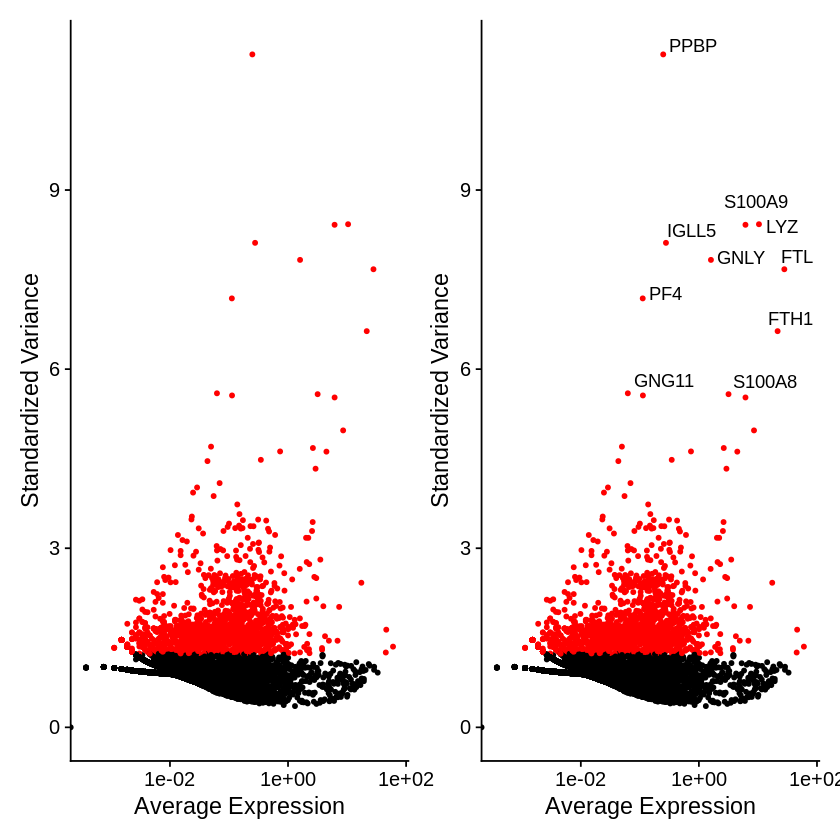

In [10]:
# Pull the top 2,000 genes
# selection.method : methods to choose the variable features
#                    vst, 
# nfeatures        : number of features to select
pbmc <- FindVariableFeatures(
    pbmc, 
    selection.method = "vst", 
    nfeatures = 2000
)

# Identify the 10 most highly variable genes
# to label in the below plot
top10 <- head(VariableFeatures(pbmc), 10)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(pbmc) + NoLegend()
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE) + NoLegend()
plot1 + plot2

#### Scaling the data

Finally, we scale the data. This step is to make it easier and faster for dimensional reductions techniques (e.g. PCA) to do their calcuations. The function `ScaleData` works by:
* Centers the gene expression across cells to a mean of 0.
* Scales the expression so that the variance across cells per gene is 1.

This can be a very slow process.

In [11]:
all.genes <- rownames(pbmc)
pbmc <- ScaleData(pbmc, features = all.genes)

Centering and scaling data matrix



*We are finished with the old normalization methods, and will be continuing from here with the results from sctransform.*

One thing to note in differences from sctransform and the previous normalization method is that sctransform preserves the information from all genes, and not just the most variable genes.

## Dimensional reduction with PCA

We want to first decorrelate the data. This results in:
1. Genes with high correlation being compressed together.
2. The ability to ignore higher dimensions as not contributing much to the data - i.e. noise.
    * This results in reducing the dimensions
We do this decorrelation with principal compoenent analysis.

One advantage of using sctransform over the previous normalization method is that more PCA components can be used in downstream analyses. In the alternative and previously used normalization methodology, you will have to try to minimize the dimensions of PCA used. Whereas, sctransform can let you use a significant number of components - e.g. 40.

In [21]:
pbmc <- RunPCA(pbmc, verbose = FALSE)

Once we have the PCA information, we can start to do so preliminary analysis to gain some insights into what is globally driving variation across the cell population. One of the first things we can analyze is what genes are contributing the to each principal component - i.e. what are the most variant genes that are also correlated.

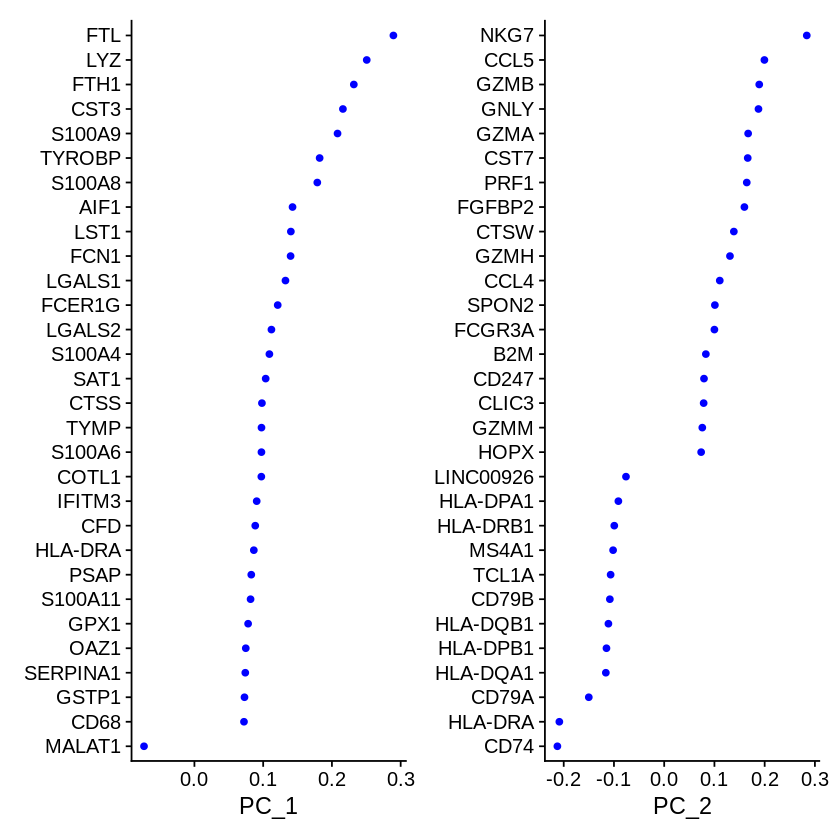

In [22]:
# This function visualizes the 'loadings' that go in the components of PCA 
# - i.e. the gene contributions to that PC.
# dim       : number of dimensions to display
#             e.g. in PCA the components to dis
# reduction : the dimensionality reduction to display
#             while in this example we use pca, 
#             we could use UMAP, TSNE, etc. that Seurat offers
VizDimLoadings(
    pbmc,
    dims = 1:2,
    reduction = 'pca'
)

Then we can look at a simple scatter plot of the PCA components. This will give you an idea of clustering, the extent of variation in each component, and the extent of heterogeneity along these components. This last one can give you an idea of how many components to include in further downstream analyses.

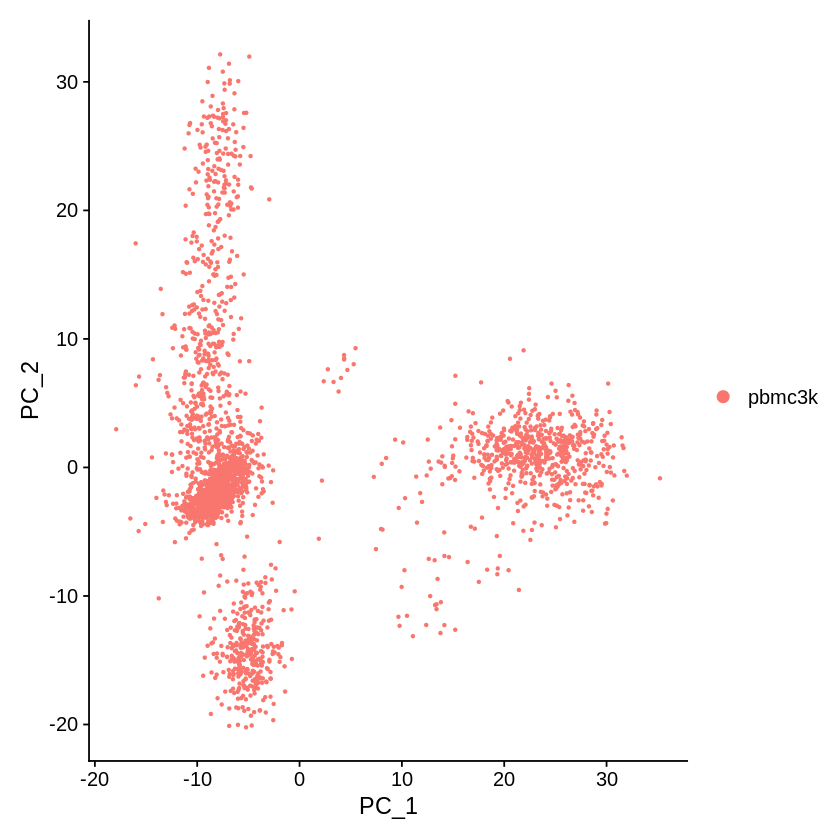

In [23]:
DimPlot(pbmc, reduction = 'pca')

### Identifying the dimensionality of the data (PCA)

As a means to reducing the 'curse of dimensionality' for clustering, PCA is used to reduce the dimensionality. Thereby, the PCA components are used as input for further downstream analysis: t-SNE, UMAP, clustering, etc. However, it is a good idea to get an idea of the extent of the dimensionality still present after PCA. To this end we have a visualization of the PCA data to identify the extent of variance explained by PCA components.

A simple and less computationally taxing procedure is the elbow plot. Here, the principal components are ranked by percentage of variance explained, and this variance plotted. After the inflection point, there are diminishing returns of a component's contribution to explaining variance in the total dat set.

We want to ensure that the major PCA components are relatively low (under 15) so that downstream analyses can work effectively.

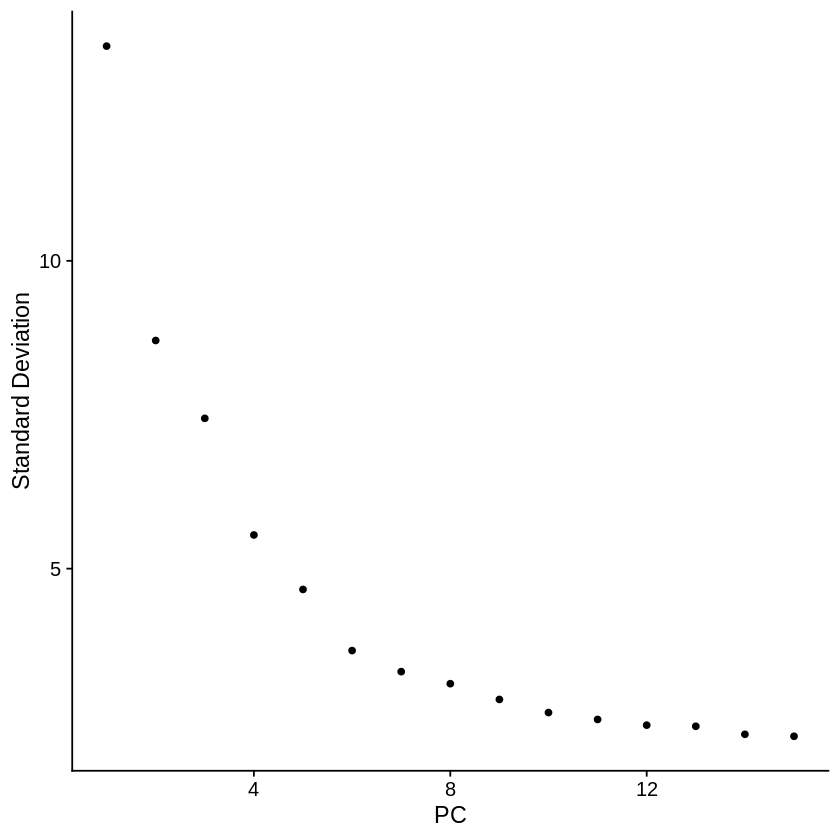

In [24]:
# We run the elbow plot for PCA
ElbowPlot(pbmc, ndims=15, reduction = 'pca')

Furhtermore, we explore the PCA heterogeniety further with a heatmap. The cells and genes are ordered according to their PCA scores. In the case of this example heatmap, we are going to limit the cells to the most extreme variance in the component. Heatmaps in general are very computationally taxing to run, so it is not recommended to run on the full gene and cell set.

Below, we create a heatmap of the first principal component only. See how the data tends to cluster.

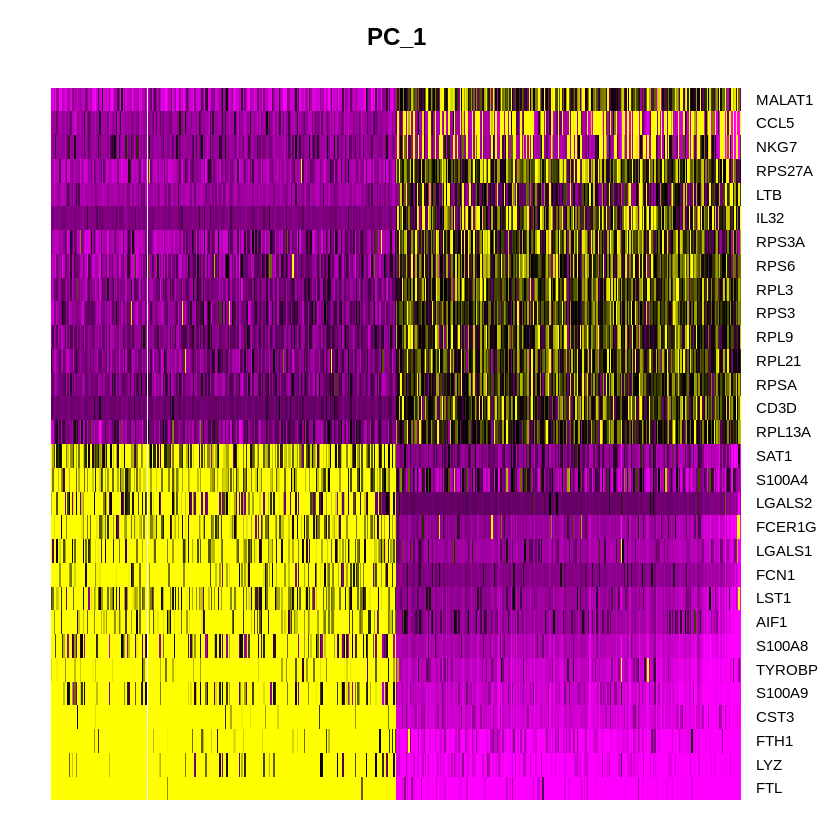

In [25]:
# dims     : the PCA components to display
# cells    : default is null (i.e. all cells), otherwise top # of cells
# balanced : plot and equal number of genes with both + and - scores
DimHeatmap(
    pbmc, 
    dims = 1, 
    cells = 500, 
    balanced = TRUE
)

Next, we may look consecutively at the components 1-8. Here we can see the degradation in the extent of variance contributed by genes in the further components values.

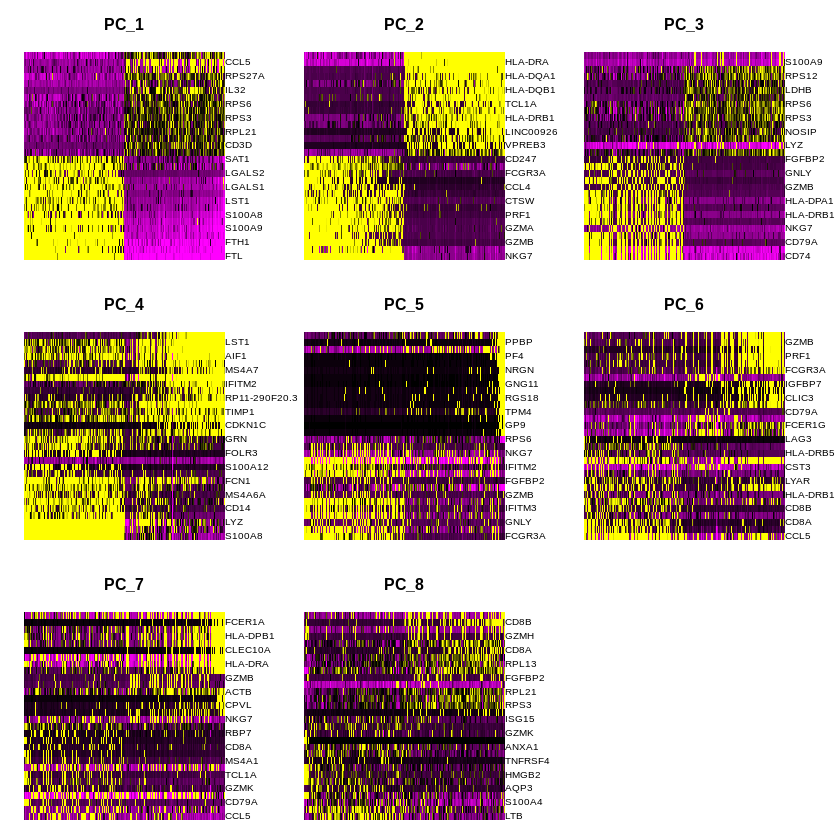

In [22]:
DimHeatmap(
    pbmc, 
    dims = 1:8, 
    cells = 500, 
    balanced = TRUE
)

### Further dimensionality reduction with UMAP

Then we want to further reduce dimensions - for visualization - with UMAP (additionally t-SNE can be performed in a similar manner). The outputs will be stored in the Seurat object under reductions. These outputs will be used for visualization, and not as input to downstream analysis with clustering.

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
10:44:02 UMAP embedding parameters a = 0.9922 b = 1.112

10:44:02 Read 2700 rows and found 40 numeric columns

10:44:02 Using Annoy for neighbor search, n_neighbors = 30

10:44:02 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

10:44:04 Writing NN index file to temp file /tmp/RtmpTm68GR/file130e1f814f4b

10:44:04 Searching Annoy index using 1 thread, search_k = 3000

10:44:05 Annoy recall = 100%

10:44:05 Commencing smooth kNN distance calibration using 1 thread

10:44:06 Initializing fr

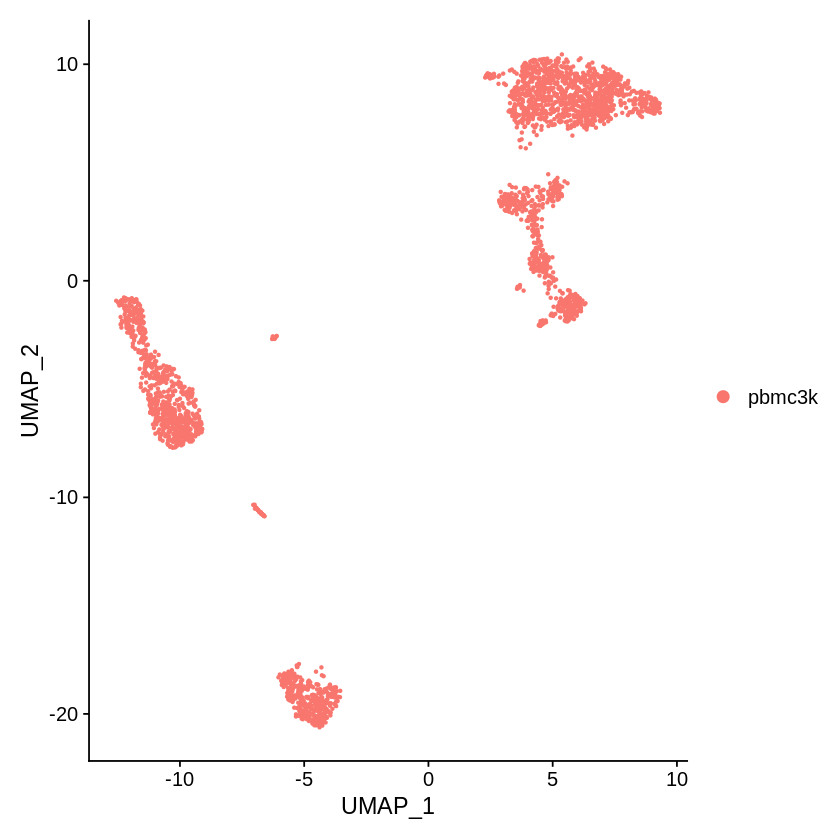

In [26]:
# If you haven't installed UMAP, you can do so via reticulate::py_install(packages =
# 'umap-learn')

# For the input dims for UMAP, you can base it off your data - i.e. from your elbow plot
# dims : number of components from PCA to use
#        in the example below, components 1 - 40
pbmc <- RunUMAP(
    pbmc, 
    dims = 1:40, 
    seed.use = 42
)
# Note, that I have fixed the random seed to 42 so that all UMAPs produced
# this session should look the same.

# t-SNE is invoked similarly to UMAP.
# For now I have commented it out so we can focus on the rest of the downstream
# analysis, as the t-SNE process is fairly slow.
# pbmc <- runTSNE(pbmc, dims = 1:40)

# Plot the UMAP embeddings
DimPlot(pbmc, reduction = 'umap')

Additionally, the default values will only give you an approximate visualization of UMAP's projected low dimensional mapping. To get the best compression of the higher dimensional PCA inputs to UMAP, you will need to optimize parameters. However, this is outside the scope of this workshop. Suffice to say, the default configuration for UMAP will give you a rough estimate of the visualization of clusters, but there is the potential that it is not entirely optimal.

## Clustering the cells

Here, we apply a graph-based clustering approach to cluster the cell from the data. This is the KNN-SNN based approach mentioned the other day. This method has two advantages:

1. It is non-parametric in it's cluster partitioning.
2. It automatically determines the number of clusters.

However, one should optimize some of the parameters for best usage. Typically, it has been found that for a approximately 3K cell data set, the resolution parameter is best set for between 0.4 - 1.2. A smaller value, at 3K cells, is tuning the clustering process to identify more clusters. With larger data sets, a larger resolution value may be required for similar results. You can use your UMAP visualization to aid in the choice of optimal resolution paramter value.

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2700
Number of edges: 130387

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8766
Number of communities: 10
Elapsed time: 0 seconds


Warning message:
“Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session.”


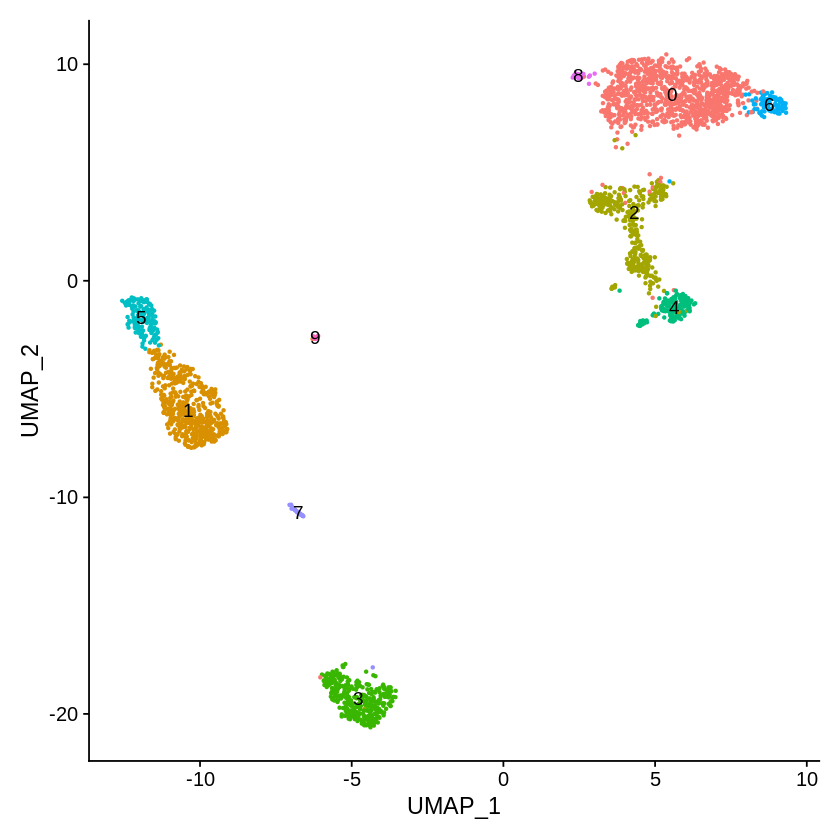

In [27]:
# This is a two step process
# First, identify the neighbors for each cell, this is the KNN part
# FindNeighbors by default uses the PCA reduction
pbmc <- FindNeighbors(pbmc, reduction = 'pca', dims = 1:40)
# Second, partition the clusters from this KNN graph
pbmc <- FindClusters(pbmc, resolution = 0.5)

# Then visualize these clusters against the UMAP.
DimPlot(pbmc, reduction = 'umap', label = TRUE) + NoLegend()

Finally, we should perform a sanity check for the results of the clustering - if possible. If we know of some canonical biomarkers, we can check to ensure that the clustering - at least for the cells expressing the biomarker - makes sense.

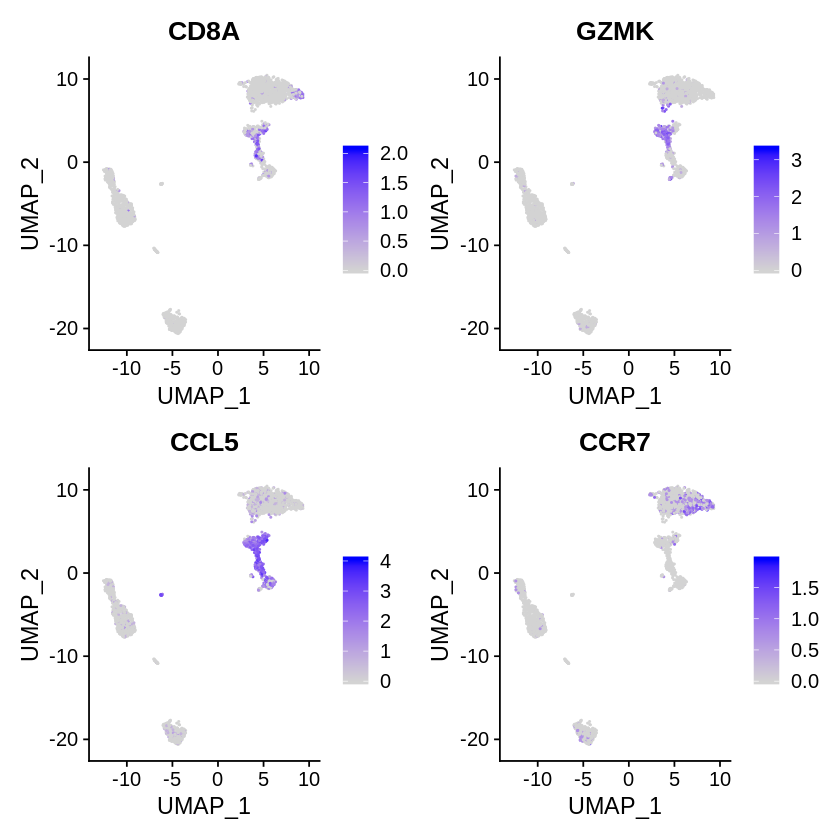

In [28]:
# Visualize canonical marker genes on the sctransform embedding.
#
# object   : Seurat object
# features : list of genes to plot
# pt.size  : size of the individual dots representing each cell
# ncol     : # of columns to display side by side
FeaturePlot(
    object = pbmc, 
    features = c("CD8A", "GZMK", "CCL5", "CCR7"),
    pt.size = 0.2, 
    ncol = 2
)

## Fine tuning clusters and visualization

There are a number of considerations to account for when clustering the cells:
1. Number of PCA components to use in computation
2. The parameters used in UMAP
3. The parameters used in the KNN / graph-based clustering

### Choosing the appropriate number of PCA components to use

Choosing the appropriate number of PCA components to use is an important choice for the loadings into UMAP and your graph-based clustering. After a certain point, PCA provides diminishing returns for explaining differences between cells. At some point, PCA is simply returning noise. It is prudent to optimize the choice in the number of components to use.

Let us revisit the elbow plot of the PCA variance.

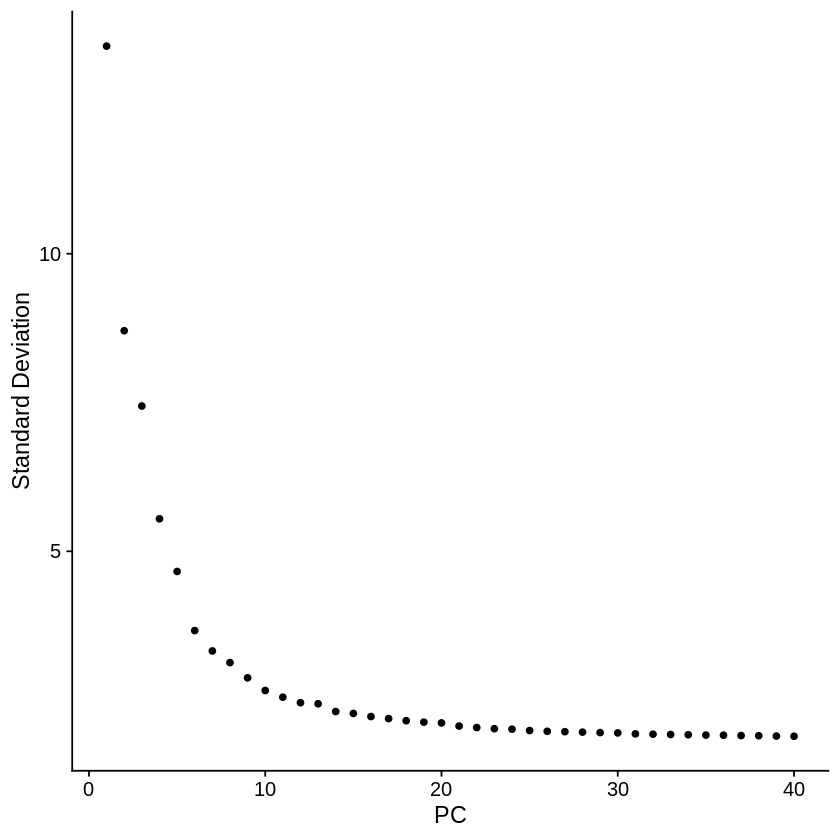

In [29]:
# We are running the elbow plot for PCA with more dimensions
ElbowPlot(pbmc, ndims=40, reduction = 'pca')

We originally used 40 dimensions into UMAP, but what happens if we were to use only the first few PCA dimensions to load into UMAP.

10:53:40 UMAP embedding parameters a = 0.9922 b = 1.112

10:53:40 Read 2700 rows and found 8 numeric columns

10:53:40 Using Annoy for neighbor search, n_neighbors = 30

10:53:40 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

10:53:41 Writing NN index file to temp file /tmp/RtmpTm68GR/file130e5ce676c3

10:53:41 Searching Annoy index using 1 thread, search_k = 3000

10:53:42 Annoy recall = 100%

10:53:42 Commencing smooth kNN distance calibration using 1 thread

10:53:43 Initializing from normalized Laplacian + noise

10:53:44 Commencing optimization for 500 epochs, with 106324 positive edges

10:53:53 Optimization finished



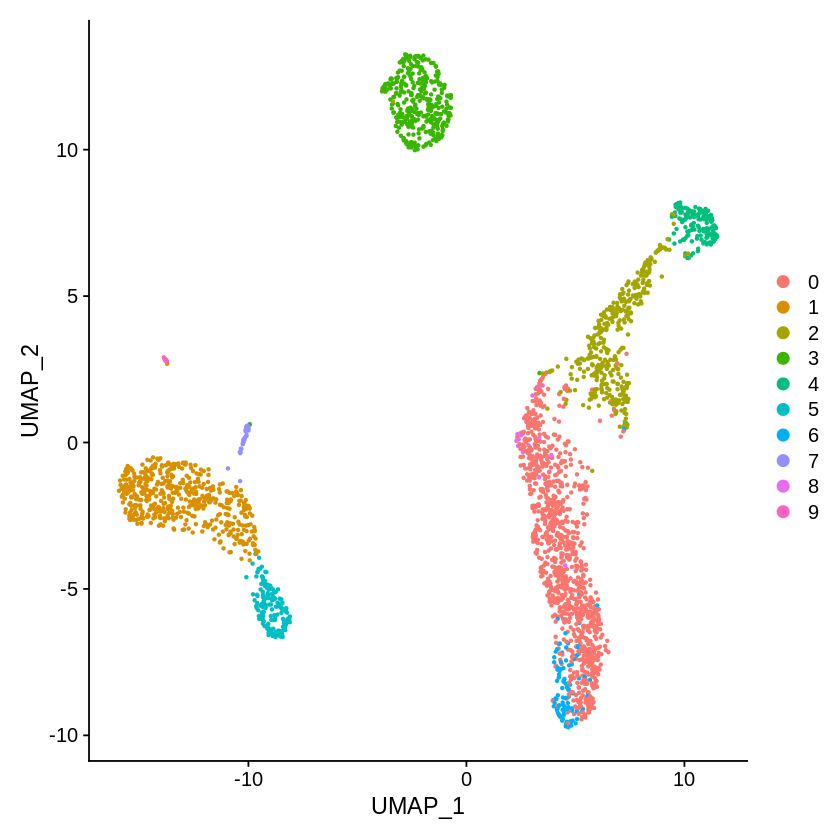

In [34]:
pbmc <- RunUMAP(
    pbmc, 
    dims = 1:8, 
    seed.use = 42
)
DimPlot(pbmc, reduction = 'umap', label = FALSE)

We see that when we use less information from reducing the number of PCA dimensions used, that we are losing a lot of fine grained subclustering. The data starts to look more like a plot of the PCA components. Looking back at the elbow plot, we can see that components 30-40 are not contributing much to the variance. The standard Seurat normalization states that the suggested maximum components to use in UMAP is 20. With scTransform, we can go up to 40. We can see from the elbow plot that 20-30 has a lot of small variance, so without scTransform we would lose that information. For these samples, we should probably aim for about 32 components, as there is little benefit to be found in the 30-40 component range and we risk further information being due to noise.

10:59:54 UMAP embedding parameters a = 0.9922 b = 1.112

10:59:54 Read 2700 rows and found 32 numeric columns

10:59:54 Using Annoy for neighbor search, n_neighbors = 30

10:59:54 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

10:59:55 Writing NN index file to temp file /tmp/RtmpTm68GR/file130e33281a9d

10:59:55 Searching Annoy index using 1 thread, search_k = 3000

10:59:56 Annoy recall = 100%

10:59:57 Commencing smooth kNN distance calibration using 1 thread

10:59:58 Initializing from normalized Laplacian + noise

10:59:58 Commencing optimization for 500 epochs, with 113824 positive edges

11:00:08 Optimization finished



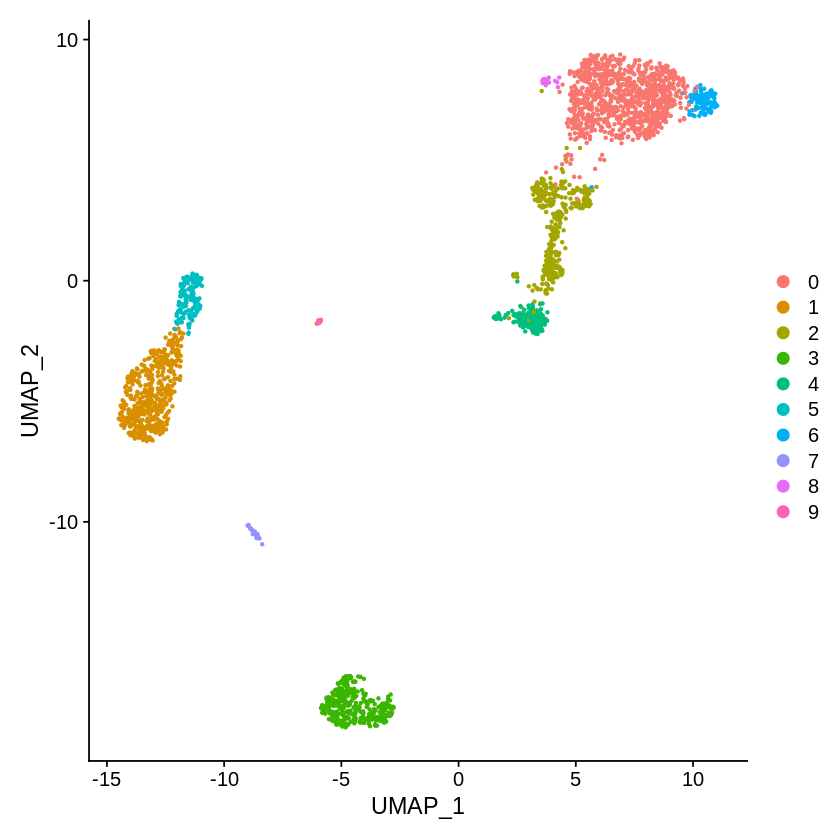

In [35]:
pbmc <- RunUMAP(
    pbmc, 
    dims = 1:32, 
    seed.use = 42
)
DimPlot(pbmc, reduction = 'umap', label = FALSE)

This plot now looks strikingly similar to the 40 dimensions plot, which is to be expected. It should be stated that there is no "right" answer to the number of components to use. There are guidelines, like I have shown above, but it will take some testing and educated guesswork. Additionally, the difference between 32 and 33 components to use is minimal. As you can see from the previous plots, there is minimal effect from simply using 40 components. However, every data set is different, and some may have particularly high variance that requires using more components.

### Tuning parameters for UMAP

We have two major parameters for adjusting UMAP. However, the parameter with the largest effect is `min.dist`. We will focus on adjusting `min.dist`. By default, RunUMAP() has a default `min.dist` of 0.3. Let us see the effect of increasing min.dist further. We want to try expanding some of these really tightly packed clusters so we can see more clearly some of the subclusters' densities.

12:08:45 UMAP embedding parameters a = 0.115 b = 1.929

12:08:45 Read 2700 rows and found 32 numeric columns

12:08:45 Using Annoy for neighbor search, n_neighbors = 30

12:08:45 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

12:08:46 Writing NN index file to temp file /tmp/RtmpTm68GR/file130e2ffde315

12:08:46 Searching Annoy index using 1 thread, search_k = 3000

12:08:47 Annoy recall = 100%

12:08:47 Commencing smooth kNN distance calibration using 1 thread

12:08:48 Initializing from normalized Laplacian + noise

12:08:48 Commencing optimization for 500 epochs, with 113824 positive edges

12:08:58 Optimization finished



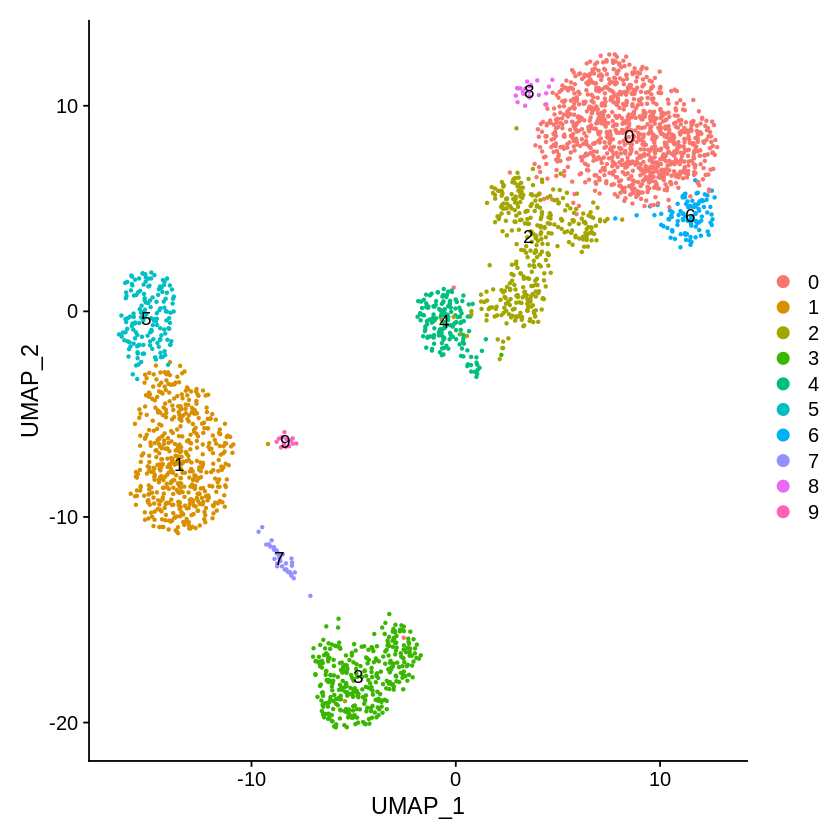

In [37]:
pbmc <- RunUMAP(
    pbmc, 
    dims = 1:32, 
    min.dist = 1.0,
    seed.use = 42,
)
DimPlot(pbmc, reduction = 'umap', label = T)

How about if we really want to identify the contours of various subclusters? We will push min.dist lower, to increase the density of idividual clusters.

12:11:05 UMAP embedding parameters a = 1.645 b = 0.8737

12:11:05 Read 2700 rows and found 32 numeric columns

12:11:05 Using Annoy for neighbor search, n_neighbors = 30

12:11:05 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

12:11:06 Writing NN index file to temp file /tmp/RtmpTm68GR/file130e5e054106

12:11:06 Searching Annoy index using 1 thread, search_k = 3000

12:11:07 Annoy recall = 100%

12:11:08 Commencing smooth kNN distance calibration using 1 thread

12:11:09 Initializing from normalized Laplacian + noise

12:11:09 Commencing optimization for 500 epochs, with 113824 positive edges

12:11:18 Optimization finished



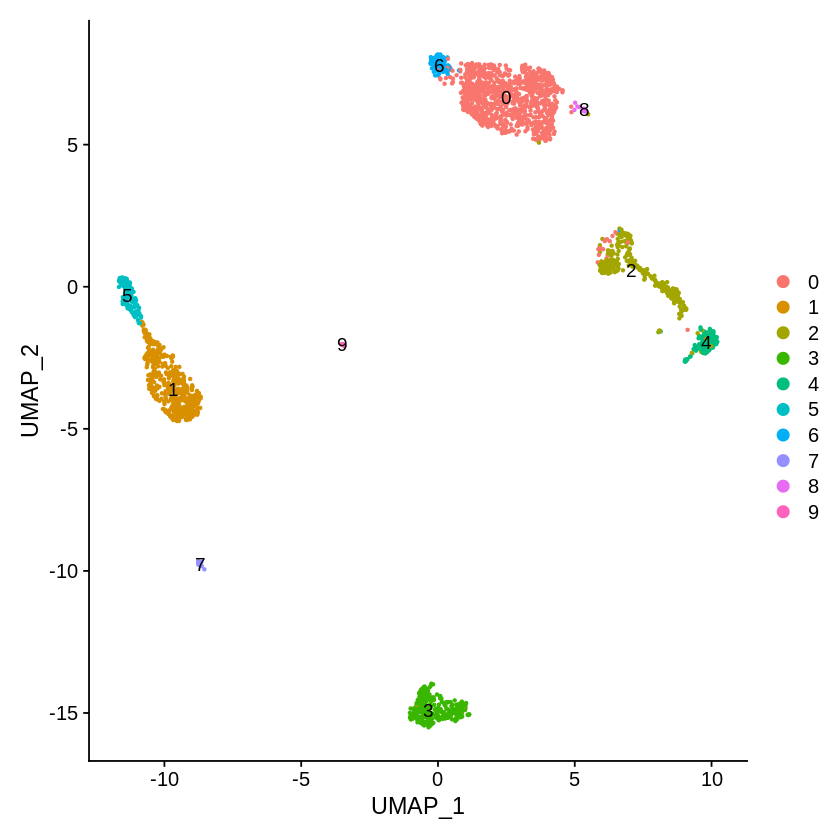

In [39]:
pbmc <- RunUMAP(
    pbmc, 
    dims = 1:32, 
    min.dist = 0.08,
    seed.use = 42,
)
DimPlot(pbmc, reduction = 'umap', label = T)

After loooking at the default, the increased `min.dist`, and the decreased, let us go with a value of 0.7. It will let us view the spread of cells within the clusters better, while not blurring the boundaries between clusters and subclusters too much.

12:13:23 UMAP embedding parameters a = 0.3208 b = 1.563

12:13:23 Read 2700 rows and found 32 numeric columns

12:13:23 Using Annoy for neighbor search, n_neighbors = 30

12:13:23 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

12:13:24 Writing NN index file to temp file /tmp/RtmpTm68GR/file130e506eef79

12:13:24 Searching Annoy index using 1 thread, search_k = 3000

12:13:25 Annoy recall = 100%

12:13:26 Commencing smooth kNN distance calibration using 1 thread

12:13:27 Initializing from normalized Laplacian + noise

12:13:27 Commencing optimization for 500 epochs, with 113824 positive edges

12:13:36 Optimization finished



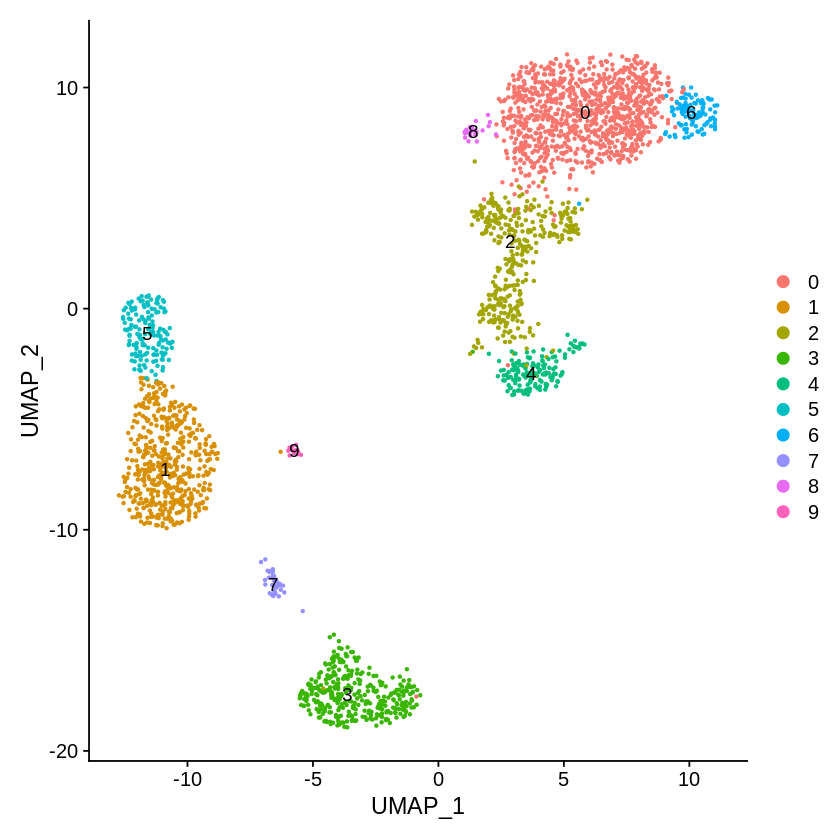

In [40]:
pbmc <- RunUMAP(
    pbmc, 
    dims = 1:32, 
    min.dist = 0.7,
    seed.use = 42,
)
DimPlot(pbmc, reduction = 'umap', label = T)

### Tuning parameters for KNN / graph-based clustering

We can see that the default parameters for KNN / graph-based clustering could probably use refinement. Cluster 2 in particular could probably be separated in two clusters. Possibly the same for cluster 3. Additionally, the tag sticking out of cluster 4 may be able to be separated.

For KNN, we will stick with the default `k.param` of 20. It's a good balance of information and computational speed. Increasing k will only result in promoting global structure to the clustering - losing granularity. However, if the next steps do not suffice, you may consider changing `k.param`.

In [41]:
# Running the KNN portion that builds out the graph
# We are running mostly default parameters - with 
# 32 components being used.
pbmc <- FindNeighbors(
    pbmc, 
    reduction = 'pca', 
    dims = 1:32,
    k.param = 20,
    seed.use = 42
)

Warning message:
“The following arguments are not used: seed.use”
Warning message:
“The following arguments are not used: seed.use”
Computing nearest neighbor graph

Computing SNN



The majority of the cluster tuning is best done in the FindClusters section. This adjust the granularity with which Seurat will try clustering from the graph created by `FindNeighbors()`. We know that increasing resolution will increase granularity, so let us try to increase resolution from 0.5 to 1.0.

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2700
Number of edges: 120190

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8022
Number of communities: 13
Elapsed time: 0 seconds


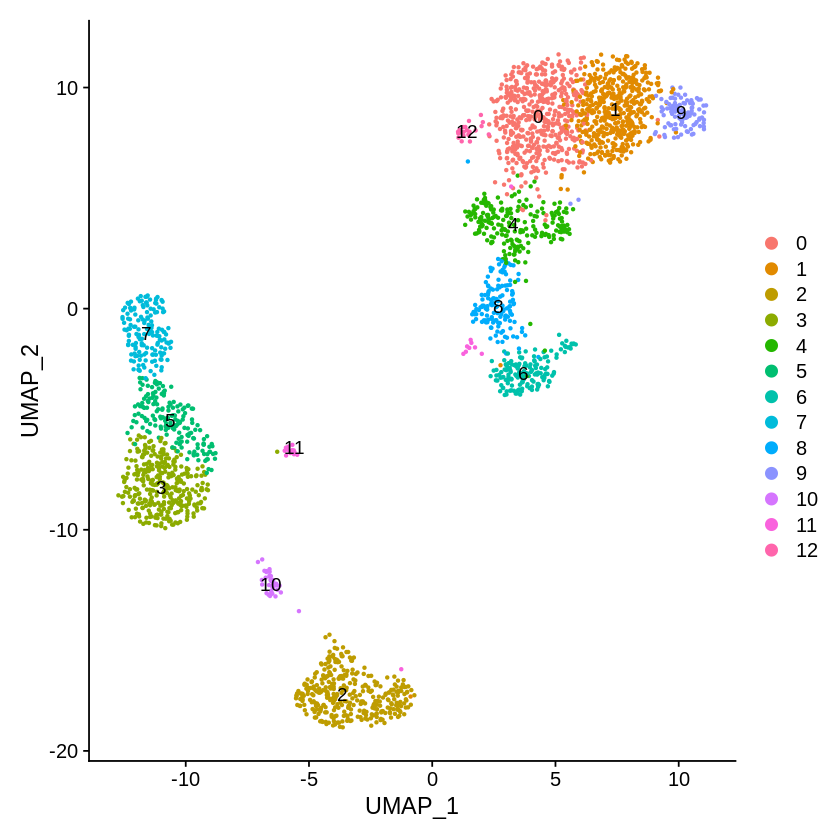

In [52]:
pbmc <- FindClusters(
    pbmc, 
    resolution = 1.0
)
DimPlot(pbmc, reduction = 'umap', label = T)

This may be too granular. With resolution, a little goes a long way. Let us try to find a middle ground.

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2700
Number of edges: 120190

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8474
Number of communities: 11
Elapsed time: 0 seconds


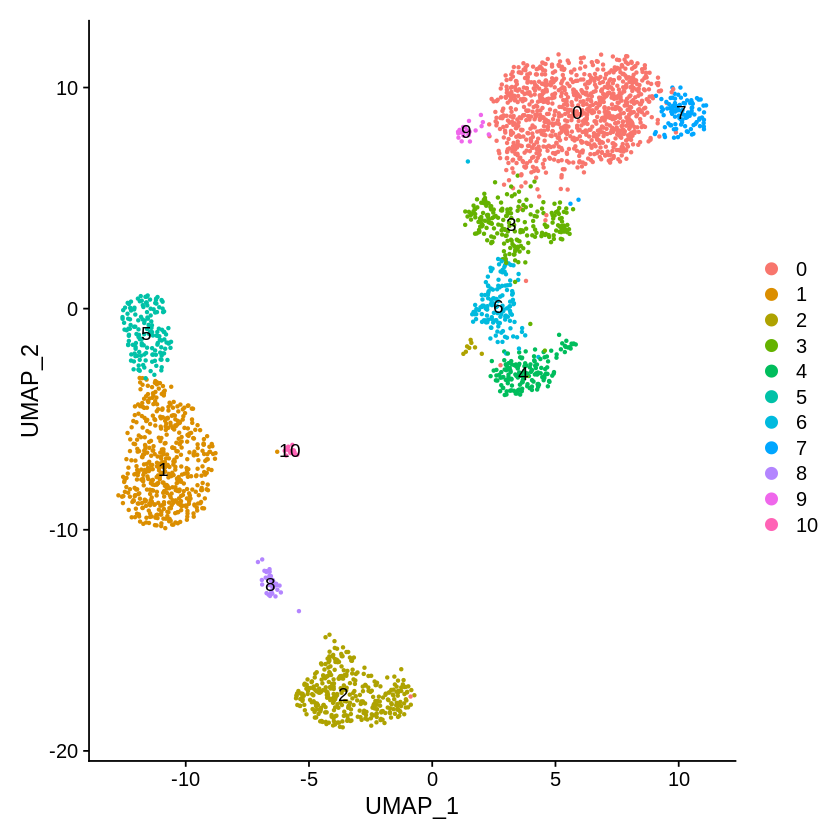

In [55]:
pbmc <- FindClusters(
    pbmc, 
    resolution = 0.65
)
DimPlot(pbmc, reduction = 'umap', label = T)

This looks pretty good. Maybe we believe that cluster 2 should be split, however, cluster 0 will take priority. A dense cluster of points like cluster 0 will be prioritized when resolution increases. For now, we will stick with a resolution of 0.65.

### Labeling cell clusters by cell type

Let us use our scMatch cell type annotations to label the cells. In the scMatch annotations, each individual cell is annotated. This may not align perfectly with our clusters, though in aggregate it should.

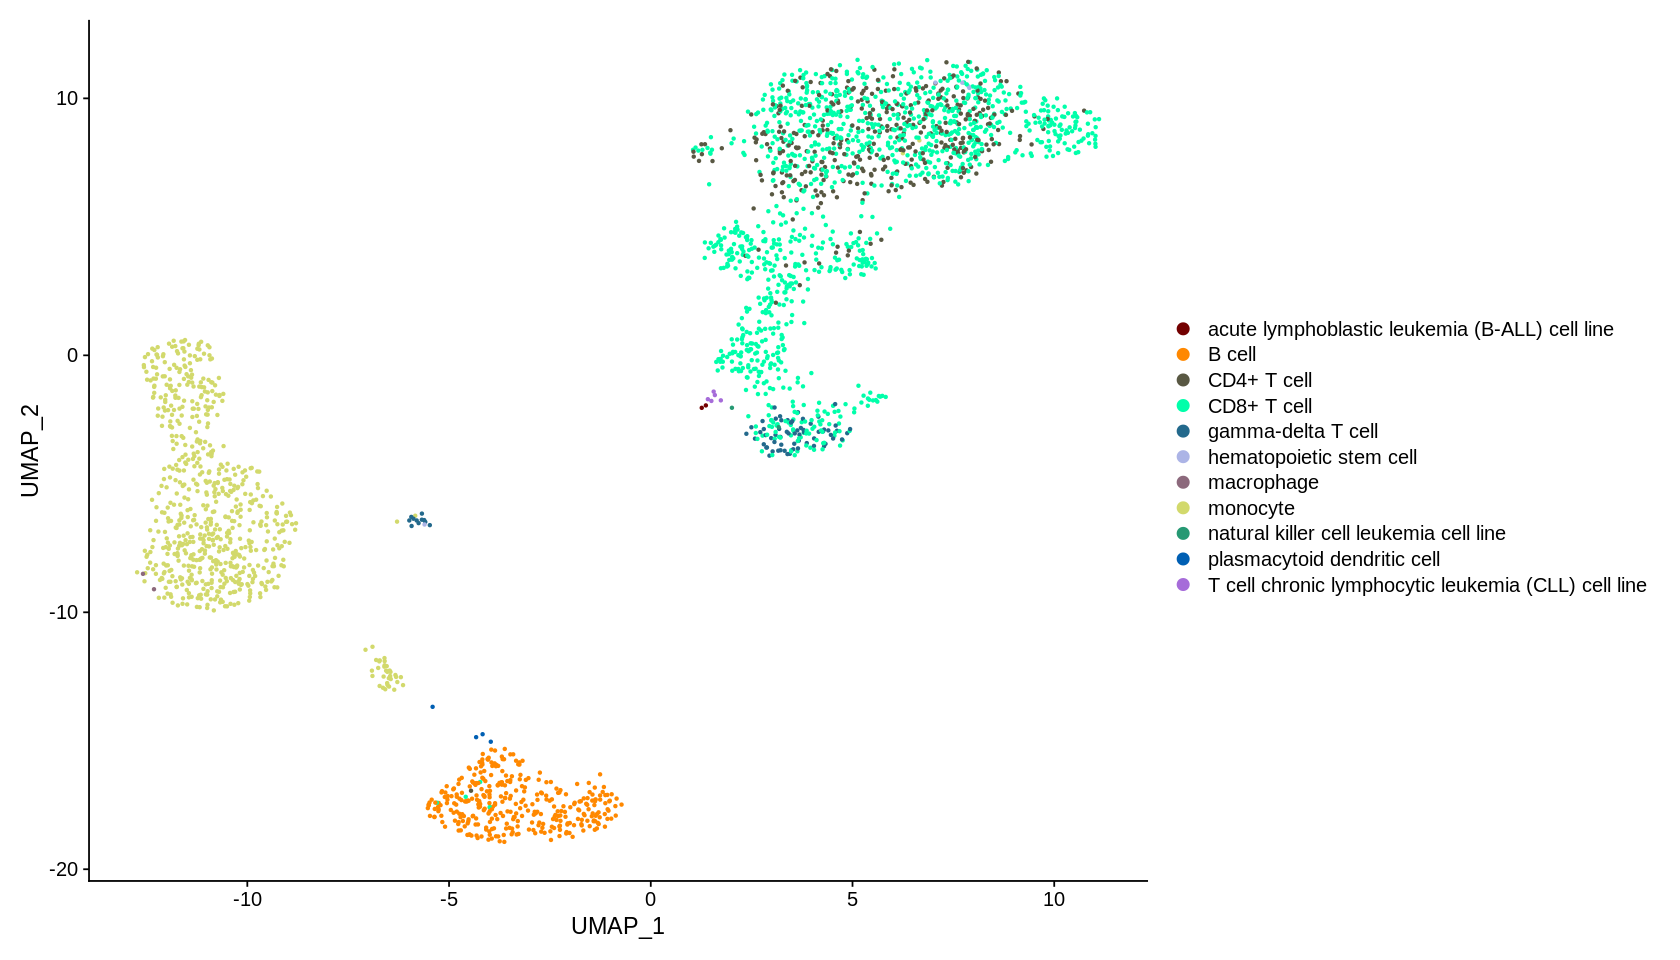

In [63]:
# We will define our own list of colors to improve clarity
colors = c(
    "#730000", "#ff8800", "#595843", "#00ffaa", 
    "#23698c", "#acb4e6", "#8c697c", 
    "#d2d96c", "#269973", "#005fb3", 
    "#a66cd9", "#330014", "#d9a3a3", "#d9a66c", 
    "#bfff40", "#00ffee", "#262d33", "#603973", 
    "#d93677", "#ff2200", "#ffbf40"
)
DimPlot(
    pbmc,
    reduction = 'umap',
    group.by = 'scmatch_celltype',
    cols = colors
)

However, quite a few of these cell type calls are wrong classifications. This will happen at a low rate, so we can identify these and just filter them.

In [67]:
# Here we get the cell types and their respective count of cells
table(pbmc@meta.data$scmatch_celltype)


     acute lymphoblastic leukemia (B-ALL) cell line 
                                                  2 
                                             B cell 
                                                346 
                                        CD4+ T cell 
                                                375 
                                        CD8+ T cell 
                                               1202 
                                 gamma-delta T cell 
                                                 74 
                            hematopoietic stem cell 
                                                  5 
                                         macrophage 
                                                  2 
                                           monocyte 
                                                683 
             natural killer cell leukemia cell line 
                                                  2 
                        plasmacytoid dendriti

Only B cells, CD4+ T cell, CD8+ T cell, gamma-delta T cell, and monocyte were found in any appreciable quantity. We will only look at those, to clean up the UMAP plot and call clusters.

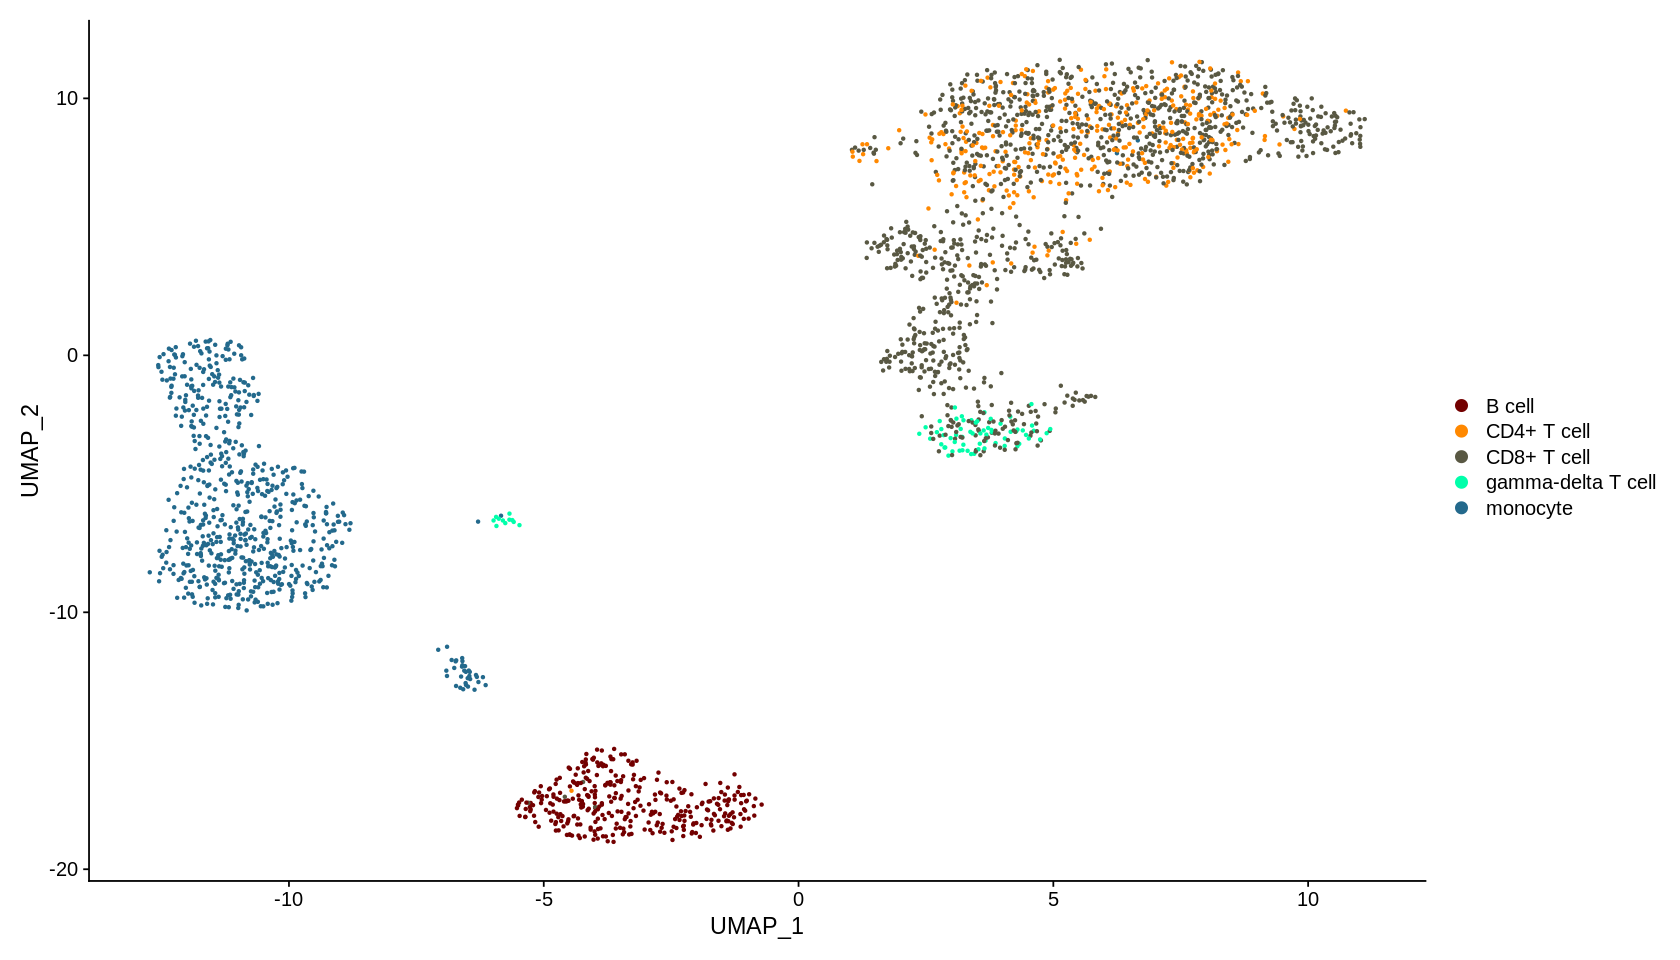

In [73]:
celltypes_of_interest <- c(
    "B cell",
    "CD4+ T cell",
    "CD8+ T cell",
    "gamma-delta T cell",
    "monocyte"
)
pbmc.sub <- subset(
    pbmc,
    subset = scmatch_celltype %in% celltypes_of_interest
)
DimPlot(
    pbmc.sub, 
    reduction = 'umap', 
    group.by = 'scmatch_celltype',
    cols = colors
)

Let us try to validate how accurate these cell type calls are with a few biomarkers.

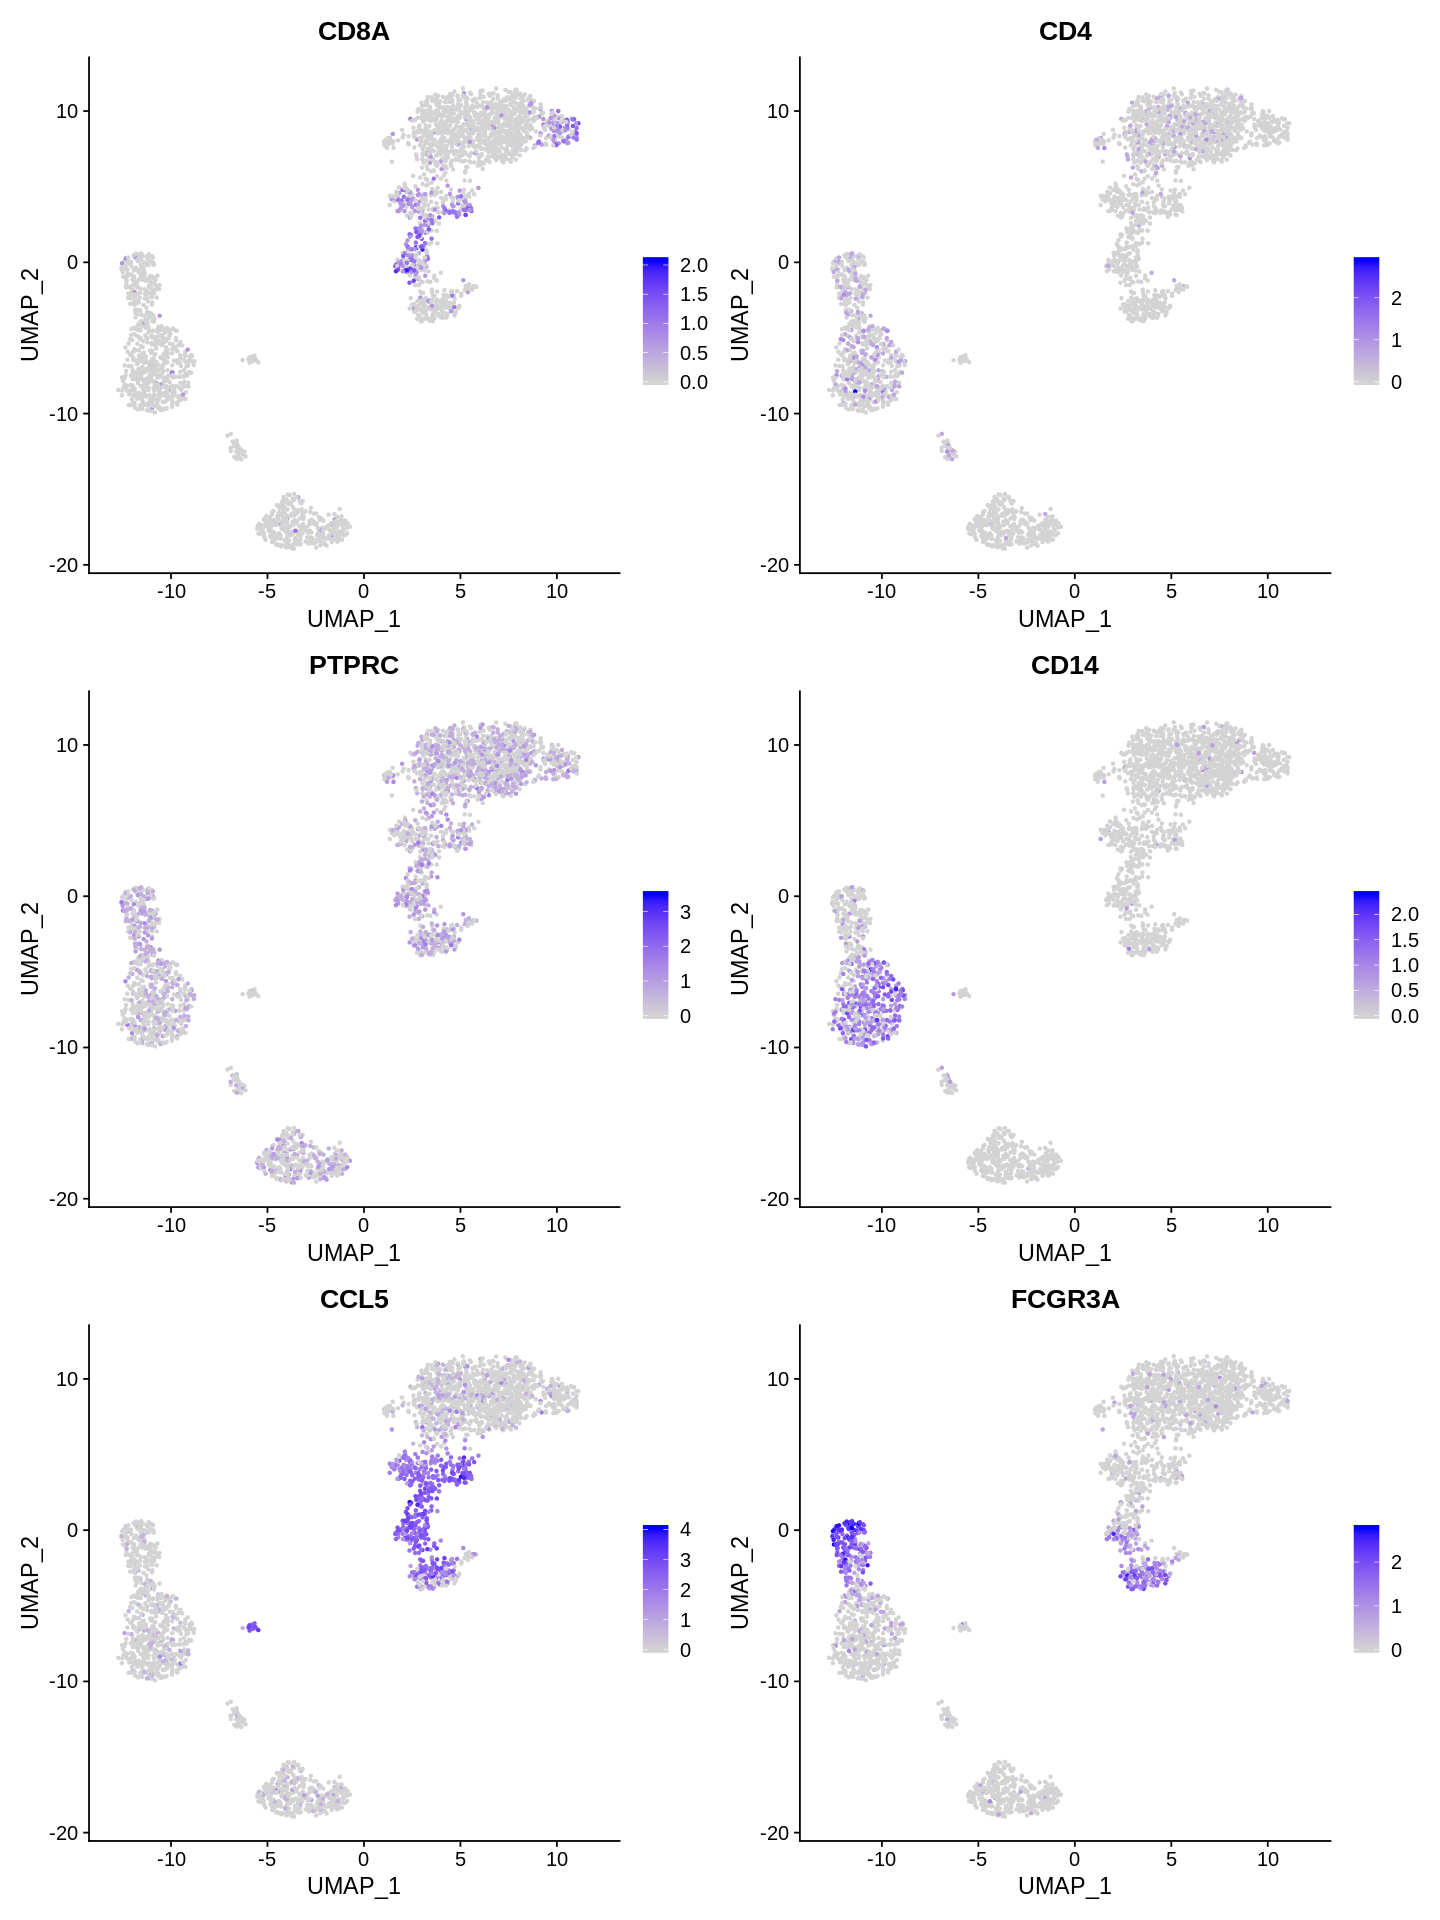

In [105]:
markers = c(
    "CD8A", "CD4", "PTPRC",
    "CD14", "CCL5", "FCGR3A"
)
FeaturePlot(
    pbmc.sub,
    features = markers,
    ncol = 2
)

Let us assume that the scMatch cell typing is mostly correct. Let us try to change our cluster names from numbers to cell types. First let us plot the two plots side by side, so that we can reconcile the clusters.

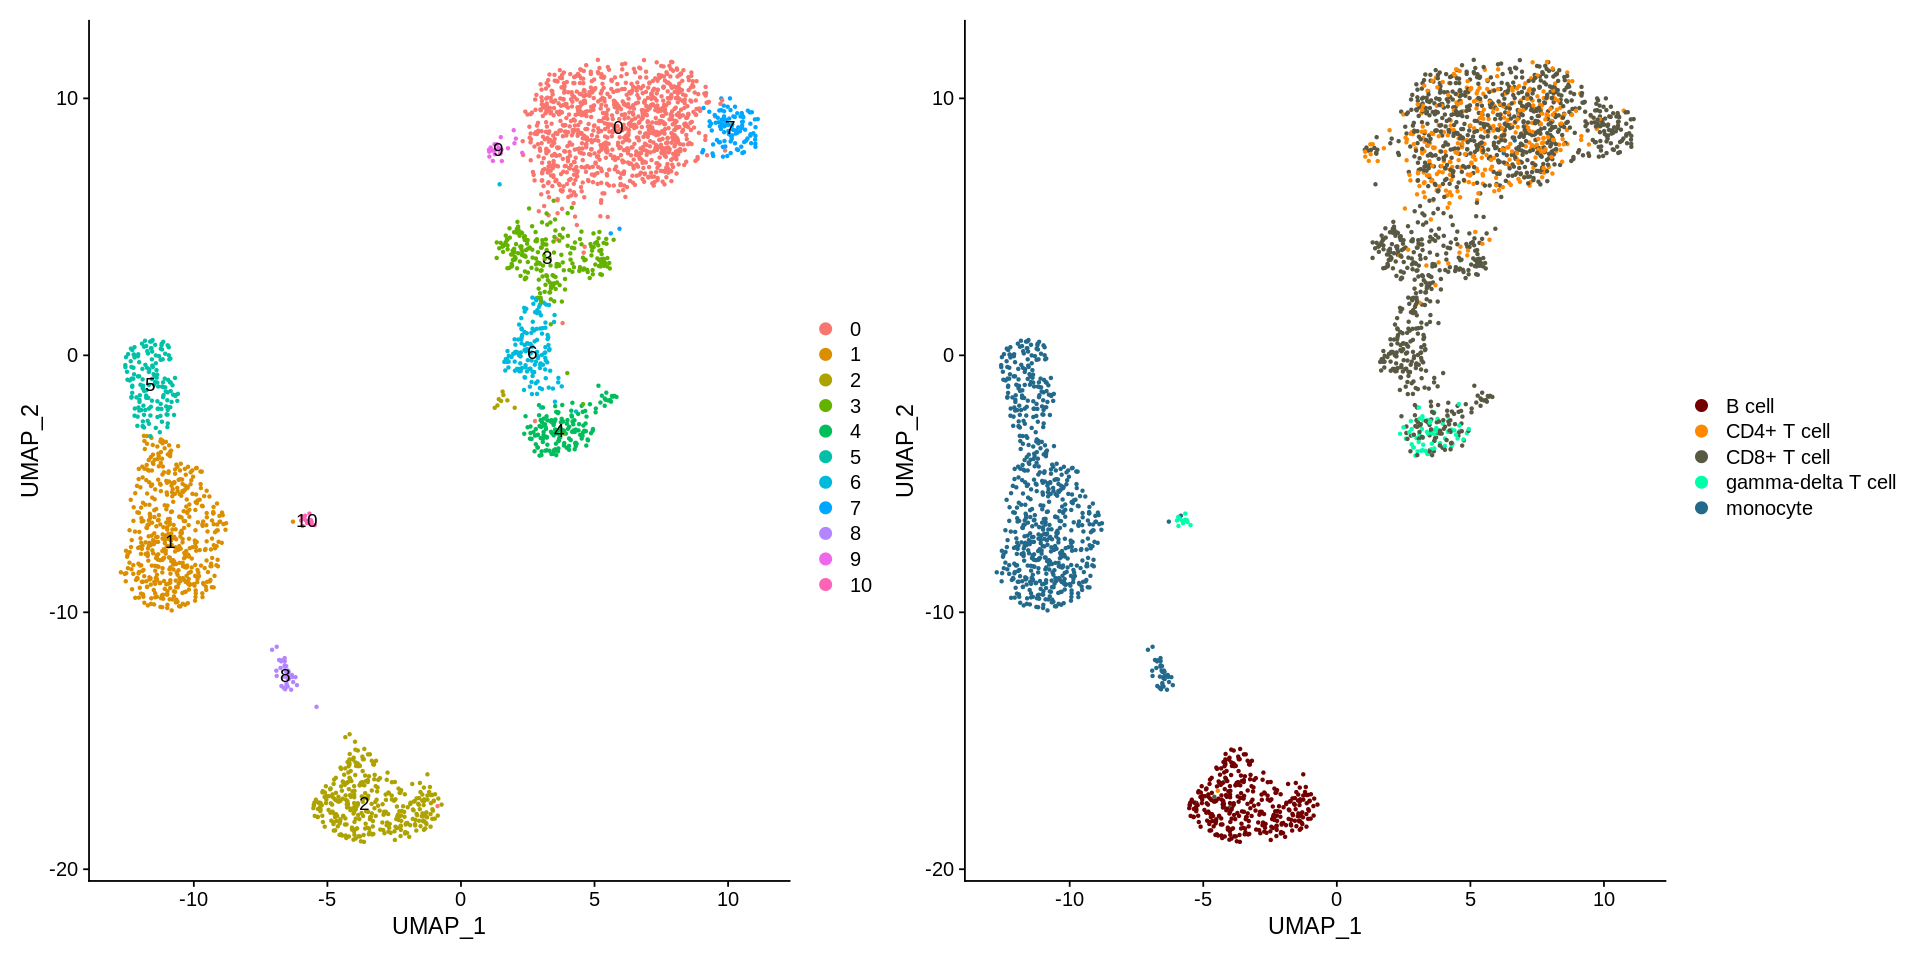

In [97]:
sc <- DimPlot(
    pbmc.sub, 
    reduction = 'umap', 
    group.by = 'scmatch_celltype',
    cols = colors
)
clust <- DimPlot(pbmc, reduction = 'umap', label = T)
clust + sc

Looking over the two plots, we can presume there is some differentiation occuring along the CD8+ T cells. Let's assume that cluster 0 (and 7) are possible progenitors, en route to differentiation to CD8+ T cells. We can also presume that clusters 8, 9, and 10 are likely multiplets. We can confirm this with software, such as Scrublet. For now, we will label these clusters as "multiplet". So we will rename the cluster identifying names to something more human readable.

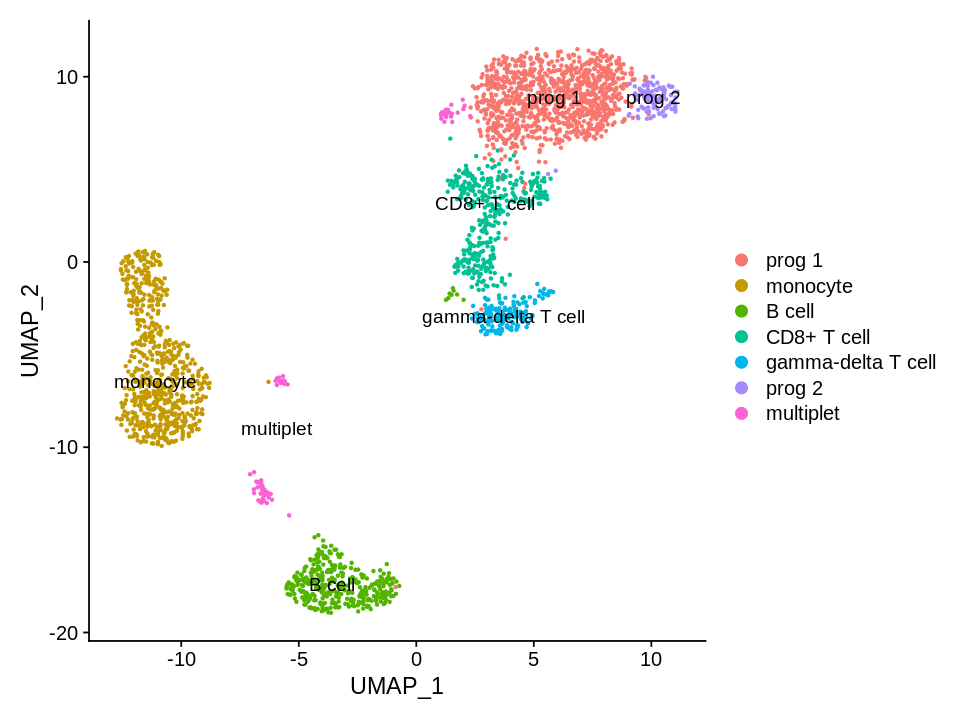

In [114]:
pbmc <- RenameIdents(
    pbmc,
    '0' = "prog 1",
    '1' = 'monocyte',
    '2' = 'B cell',
    '3' = 'CD8+ T cell',
    '4' = 'gamma-delta T cell',
    '5' = 'monocyte',
    '6' = 'CD8+ T cell',
    '7' = 'prog 2',
    '8' = 'multiplet',
    '9' = 'multiplet',
    '10' = 'multiplet'
)
DimPlot(
    pbmc,
    reduction = 'umap',
    label = T
)

## Isolating a single cluster

Now suppose we want to identify fine grained analysis of a single cluster. Will re-running PCA -> UMAP result in getting even more granular clusters? Let's find out.

15:04:15 UMAP embedding parameters a = 0.9922 b = 1.112

15:04:15 Read 649 rows and found 40 numeric columns

15:04:15 Using Annoy for neighbor search, n_neighbors = 30

15:04:15 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

15:04:15 Writing NN index file to temp file /tmp/RtmpTm68GR/file130e1c7ee4e1

15:04:15 Searching Annoy index using 1 thread, search_k = 3000

15:04:15 Annoy recall = 100%

15:04:16 Commencing smooth kNN distance calibration using 1 thread

15:04:17 Initializing from normalized Laplacian + noise

15:04:17 Commencing optimization for 500 epochs, with 27734 positive edges

15:04:20 Optimization finished



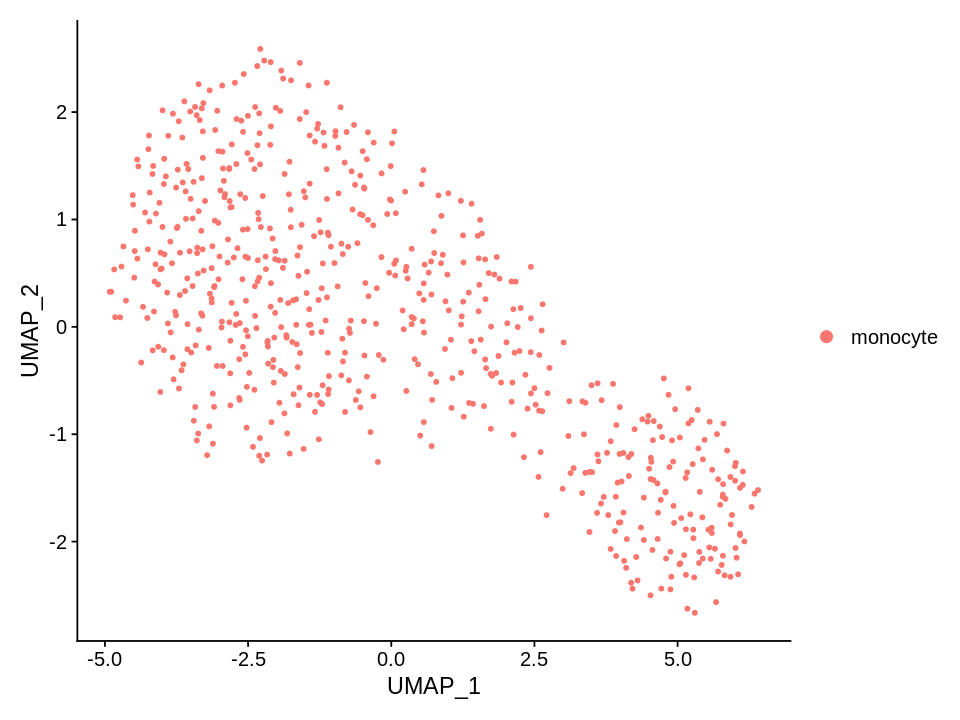

In [116]:
mono <- subset(
    pbmc,
    idents = 'monocyte'
)
mono <- RunPCA(mono, verbose = F)
mono <- RunUMAP(mono, dims = 1:40, seed.use = 42)
DimPlot(mono, reduction = 'umap')

We used the whole data set to aid in normalization, so we did not re-run normalization. We then re-ran PCA on the monocytes only, and finally re-ran UMAP. The result is that the cluster looks the same, even the scale for UMAP is roughly the same. This means that there is little advantage to re-running the dimensionality reduction. They are robust against purely local / relative values after normalization.

So, to zoom in on a particular cluster, it is better to simple filter for that cluster, and plot.

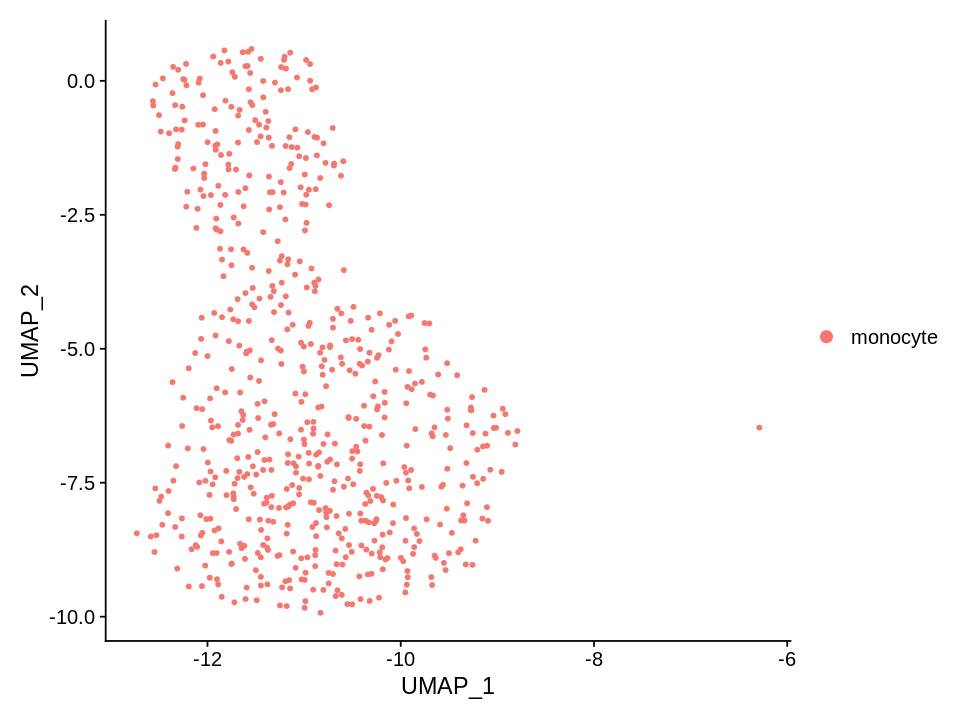

In [118]:
DimPlot(
    subset(
        pbmc,
        idents = 'monocyte'
    ),
    reduction = 'umap'
)

## Identifying marker genes from a cluster

Once we have our clusters, we may be interested in identifying the marker genes for these clusters. Let us revisit cluster x from our UMAP plot. We know that it expresses CD8A fairly uniquely compared to other cell clusters. So what other genes define the expression profile of this cluster, and where does CD8A rank in that?

We are going to find the markers for cluster 1 by differential expression against the expression of all other cells not in cluster 1 - i.e. comparing cluster 1 against background. As for the statistical test, we are going to specifically invoke MAST. MAST is a differential gene expression analysis program specifically designed for scRNASeq. However, for simply finding marker genes from background, a Wilcoxon Ran Sum test may suffice if you need to run it for computational speed reasons.

In [26]:
# Find all biomarkers for cluster 1
# ident.1  : name of vector for cell names belonging to the first group
#            in the comparison
# ident.2  : by default, all other cells - i.e. background
#            if explicitly named, the other group to compare
# test.use : Denotes which statistical test to use.
cluster1.markers <- FindMarkers(
    pbmc,
    ident.1 = "monocyte",
    test.use = "MAST"
)

# Display the top genes
head(cluster1.markers, n = 5)

Assuming data assay in position 1, with name et is log-transformed.


 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [===>----------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [====>---------------------------------


 Completed [==================================>---------]  79% with 0 failures

 Completed [==================================>---------]  80% with 0 failures

 Completed [==================================>---------]  81% with 0 failures

 Completed [===================================>--------]  81% with 0 failures

 Completed [===================================>--------]  82% with 0 failures

 Completed [===================================>--------]  83% with 0 failures

 Completed [====================================>-------]  83% with 0 failures

 Completed [====================================>-------]  84% with 0 failures

 Completed [====================================>-------]  85% with 0 failures

 Completed [=====================================>------]  85% with 0 failures

 Completed [=====================================>------]  86% with 0 failures

 Completed [=====================================>------]  87% with 0 failures

 Completed [===========================


 Completed [====================>-----------------------]  48% with 0 failures

 Completed [====================>-----------------------]  49% with 0 failures

 Completed [=====================>----------------------]  49% with 0 failures

 Completed [=====================>----------------------]  50% with 0 failures

 Completed [=====================>----------------------]  51% with 0 failures

 Completed [======================>---------------------]  51% with 0 failures

 Completed [======================>---------------------]  52% with 0 failures

 Completed [======================>---------------------]  53% with 0 failures

 Completed [=======================>--------------------]  54% with 0 failures

 Completed [=======================>--------------------]  55% with 0 failures

 Completed [=======================>--------------------]  56% with 0 failures

 Completed [========================>-------------------]  56% with 0 failures

 Completed [========================>--

p_val avg_logFC pct.1 pct.2 p_val_adj
S100A9 0     3.044202  0.992 0.210 0        
LYZ    0     2.746862  1.000 0.534 0        
S100A8 0     2.716942  0.968 0.104 0        
FTL    0     1.743696  1.000 0.990 0        
CST3   0     1.721325  0.998 0.264 0

Again, it is a good idea to perform a sanity check on the results. Here we determine just how the distribution of gene expression for cluster 1's marker genes compares to the rest of the cells. So we create a violin plot to show the distribution.

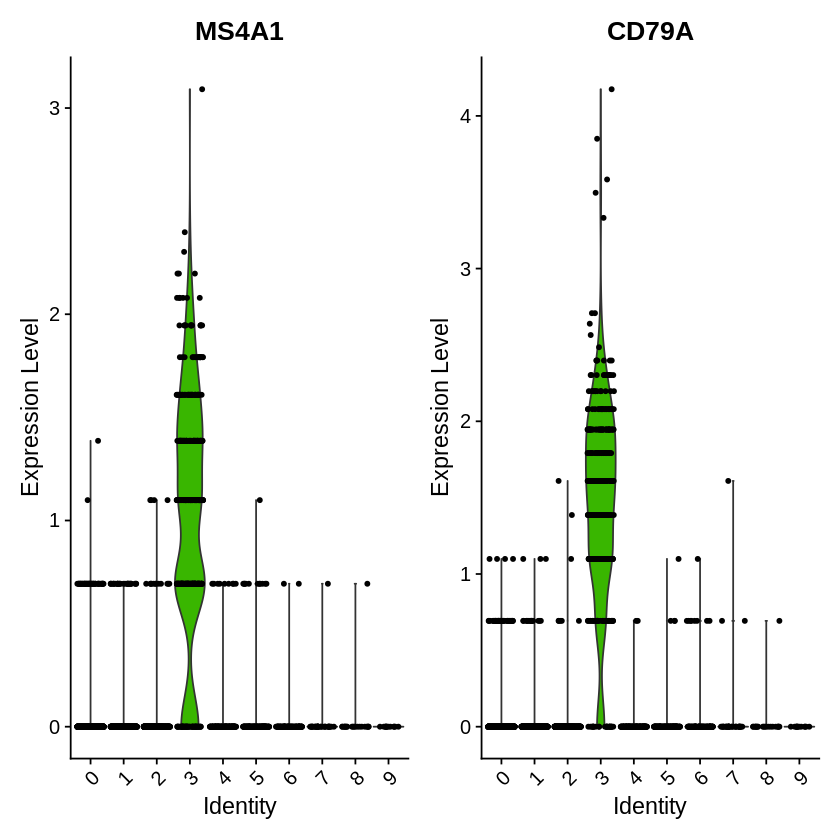

In [27]:
VlnPlot(pbmc, features = c("MS4A1", "CD79A"))

Additionally, you can just find all markers for all clusters at once. This can then be used to get a more detailed overview of the top marker genes.

In [28]:
# find markers for every cluster compared to all remaining cells, report only the positive ones
# only.pos : only return the positive / significant genes
# min.pct  : only test genes that are detected in a minimum fraction of cells in any population
#            default = 0.1
pbmc.markers <- FindAllMarkers(
    pbmc, 
    only.pos = TRUE, 
    min.pct = 0.25, 
    logfc.threshold = 0.25,
    test.use = "wilcox"
)
# For speed reasons in this workshop, I am using the Wilcoxon Rank Sum test.
# This is the default DGE algorithm in Seurat.

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9



In [29]:
# Sort all the markers by average log fold change
pbmc.markers.srt <- pbmc.markers[order(pbmc.markers$avg_logFC), ]
# Now apply the function head to all factors of 'cluster'
pbmc.markers.out <- by(pbmc.markers.srt, pbmc.markers.srt['cluster'], head, n=3)
# Let's take a look
pbmc.markers.out
#do.call("rbind", pbmc.markers.out)

cluster: 0
               p_val avg_logFC pct.1 pct.2    p_val_adj cluster    gene
C6orf48 2.861384e-30 0.2500030 0.641 0.435 3.597332e-26       0 C6orf48
EEF1B2  2.491012e-41 0.2513740 0.962 0.874 3.131700e-37       0  EEF1B2
RPL19   6.479311e-74 0.2521032 1.000 0.999 8.145789e-70       0   RPL19
------------------------------------------------------------ 
cluster: 1
              p_val avg_logFC pct.1 pct.2    p_val_adj cluster   gene
BNIP3L 1.171551e-36 0.2505443 0.341 0.117 1.472874e-32       1 BNIP3L
OAZ2   1.690030e-28 0.2508106 0.317 0.119 2.124705e-24       1   OAZ2
CSTB   1.394387e-23 0.2519033 0.537 0.309 1.753023e-19       1   CSTB
------------------------------------------------------------ 
cluster: 2
               p_val avg_logFC pct.1 pct.2    p_val_adj cluster    gene
TMEM50A 3.273501e-03 0.2562152 0.308 0.245 1.000000e+00       2 TMEM50A
CD21    1.553084e-17 0.2579718 0.481 0.279 1.952537e-13       2     CD2
LITAF   4.709034e-08 0.2583921 0.407 0.281 5.920198e-04    

Now that we have the markers for every cluster, we can see how these patterns present themselve in aggregate over all cells / clusters. We will look at everything in the top 10 against all the cells, grouped by their clusters.

Warning message in DoHeatmap(pbmc, features = top10.genes):
“The following features were omitted as they were not found in the scale.data slot for the SCT assay: ABCC3, ABHD16A, CYB5R3, STOM, ARF3, TRAT1, EVL, ELF1, SNRPD2, BASP1, LGALS9, FUOM, CCDC88A, NDUFV3, RPL14, RPL36A, RPL10, RPL23A, MTSS1, PCGF5, TCF7L2, SLC2A6, C4orf48, RNF149, MSN, EIF3G, GLIPR2, DBI, MARCH1, CD40, RPS8, LCK, RNASE6, BNIP3L, TOMM7, RPL37, LEF1, PRKCQ-AS1, SOD1”


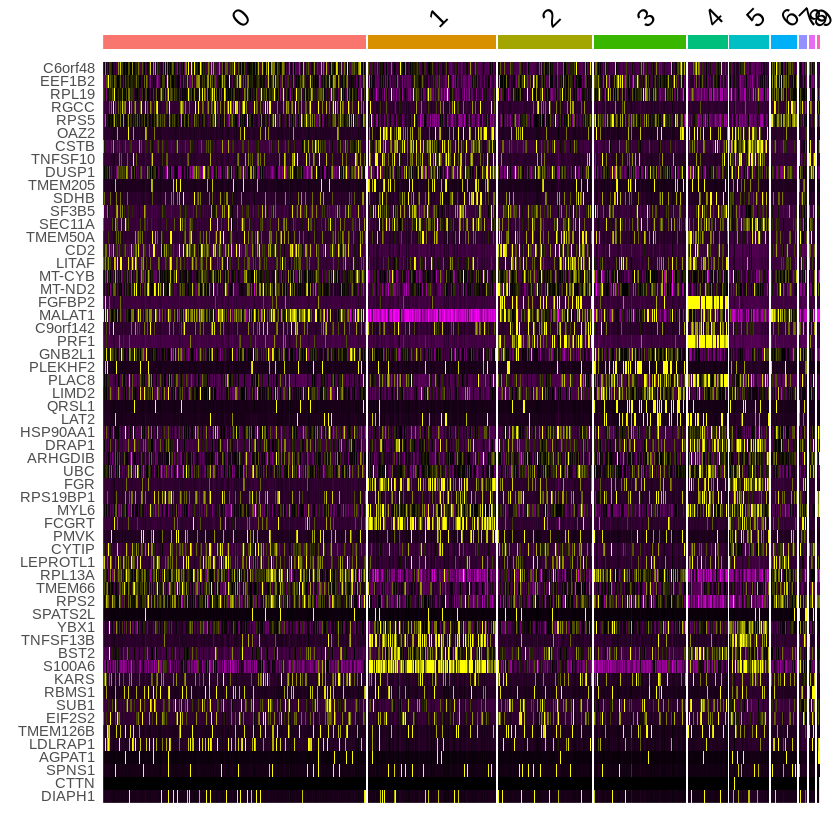

In [30]:
# Select from each cluster the top 10 genes of differential expression
# Now again apply the function head to all factors of 'cluster'
pbmc.markers.out <- by(pbmc.markers.srt, pbmc.markers.srt['cluster'], head, n=10)
# by() outputs a list of the dataframes for each cluster
# we are going to merge them with rbind
# then get the unique vector of genes
top10.genes <- do.call("rbind", pbmc.markers.out)$gene

# Plot a heatmap of all of these top 10 genes
# features : list of genes to filter for
DoHeatmap(
    pbmc,
    features = top10.genes
) + NoLegend()

## Differential gene expression analysis between clusters

Now, we can use this differential analysis to identify what makes genes differentiate two clusters of cells. For example, cluster 1 and cluster 2 share CD8A expression. Considering that it is an important biomarker, we can use differential gene analysis to determine what genes differentiate the two clusters.

In [31]:
# Find all markers of genes from cluster 1 that are differentially expressed
# from cluster 2
# ident.1  : name of vector for cell names belonging to the first group
#            in the comparison
# ident.2  : by default, all other cells - i.e. background
#            if explicitly named, the other group to compare
# logfc.threshold
#          : the minimum log fold change to consider for results of DGE
#            default is 0.25
# test.use : Denotes which statistical test to use.
cluster1.markers <- FindMarkers(
    pbmc,
    ident.1 = 1,
    ident.2 = 2,
    logfc.threshold = 0.25,
    test.use = "MAST"
)

# Display the top genes
head(cluster1.markers, n = 5)

Assuming data assay in position 1, with name et is log-transformed.


 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [===>----------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [=====>--------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------


 Completed [====================================>-------]  84% with 0 failures

 Completed [====================================>-------]  85% with 0 failures

 Completed [=====================================>------]  85% with 0 failures

 Completed [=====================================>------]  86% with 0 failures

 Completed [=====================================>------]  87% with 0 failures

 Completed [======================================>-----]  88% with 0 failures

 Completed [======================================>-----]  89% with 0 failures

 Completed [======================================>-----]  90% with 0 failures

 Completed [=======================================>----]  90% with 0 failures

 Completed [=======================================>----]  91% with 0 failures

 Completed [=======================================>----]  92% with 0 failures

 Completed [========================================>---]  92% with 0 failures

 Completed [===========================


 Completed [=========================>------------------]  59% with 0 failures

 Completed [=========================>------------------]  60% with 0 failures

 Completed [==========================>-----------------]  60% with 0 failures

 Completed [==========================>-----------------]  61% with 0 failures

 Completed [==========================>-----------------]  62% with 0 failures

 Completed [===========================>----------------]  63% with 0 failures

 Completed [===========================>----------------]  64% with 0 failures

 Completed [===========================>----------------]  65% with 0 failures

 Completed [============================>---------------]  65% with 0 failures

 Completed [============================>---------------]  66% with 0 failures

 Completed [============================>---------------]  67% with 0 failures

 Completed [=============================>--------------]  67% with 0 failures

 Completed [===========================

p_val         avg_logFC pct.1 pct.2 p_val_adj    
LYZ     0.000000e+00 3.180927  1.000 0.470  0.000000e+00
FTL     0.000000e+00 2.350735  1.000 0.992  0.000000e+00
FTH1   4.206178e-319 2.054131  1.000 0.992 5.288008e-315
TYROBP 1.238976e-283 2.266187  0.998 0.165 1.557641e-279
CST3   2.904036e-270 2.381567  0.998 0.159 3.650955e-266

Again, we can refer to the violin plots to confirm the extent of the differential expression of these genes.

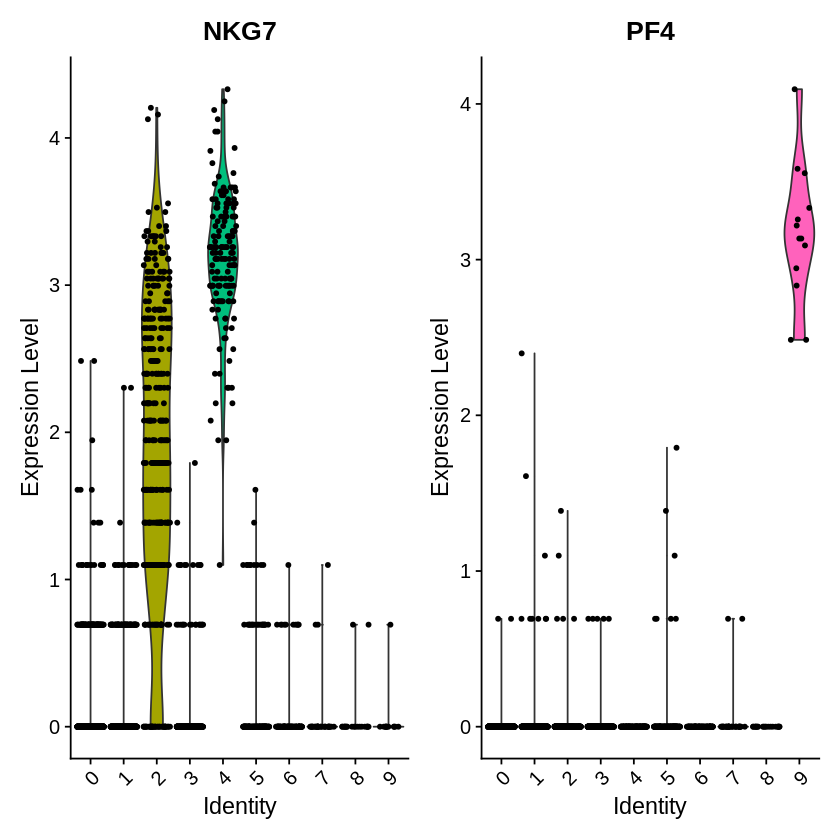

In [32]:
# Violin plot
VlnPlot(pbmc, features = c("NKG7", "PF4"))

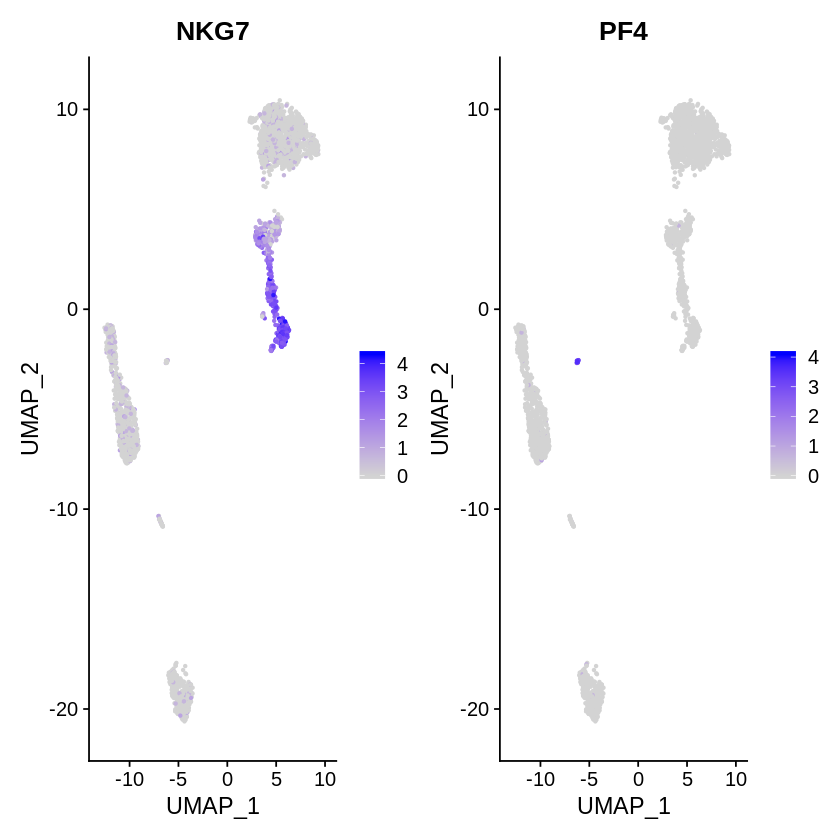

In [33]:
# Scatter plot
FeaturePlot(
    pbmc, 
    features = c("NKG7", "PF4")
)

## Integrating multiple data sets for a stimulated vs. control experiment

With this next section we aim to address two goals:
1. Provide an example of analysis comparing two conditions of otherwise similar cell cohorts.
2. How to use Seurat to combine and annotate two separate data sets.

Here, we are going to load another 10X data set of two sets of cells: a control and a stimulated set exposed for 6 hours to IFN-beta. You can get the raw data [here](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE96583).

The first steps involve loading the data like normal. Then making a list (in R) of the objects, to which we apply normalization separately.

In [34]:
# Load the 10X data
stim.data <- Read10X(data.dir = "./data/stim")
control.data <- Read10X(data.dir = "./data/control")

# Load the 10X data into a Seurat object
stim <- CreateSeuratObject(counts = stim.data, project = "stim-control")
control <- CreateSeuratObject(counts = control.data, project = "stim-control")

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [35]:
# We are going to reduce this 14K cell data set to 3K

# Identify a random assortment of cells
cells.to.sample <- sample(rownames(stim@meta.data), 3000)
# Subset the 14K dataset for the randomly selected 3K cells
stim.small <- subset(stim, cells = cells.to.sample)

# Repeat for the control
cells.to.sample <- sample(rownames(control@meta.data), 3000)
control <- subset(control, cells = cells.to.sample)

In [37]:
# Annotate the objects with the type, by a user-defined group name
control$stim <- "CONTROL"
stim$stim <- "STIM"


# Merge the Seurat objects into one object
immune.combined <- merge(
    control,
    y = c(stim),
    add.cell.ids = c("CONTROL", "STIM"),
    project = "STIM-CONTROL"
)

# Split the object by stim
ifnb.list <- SplitObject(immune.combined, split.by = "stim")

# Then, for each split object, normalize each data set individually
# We are going to use a flat normalization method for 
ifnb.list <- lapply(X = ifnb.list, FUN = function(x) {
    x <- NormalizeData(x)
    x <- FindVariableFeatures(x, selection.method = "vst", nfeatures = 2000)
})

Once we have normalized each file separately, we can move ahead with integration of the normalized points.

In [38]:
# Find integration points
immune.anchors <- FindIntegrationAnchors(object.list = ifnb.list, dims = 1:20)

# Integrate the objects based on the determined anchor points.
# This will override the previous immune.combined object.
immune.combined <- IntegrateData(anchorset = immune.anchors, dims = 1:20)

Computing 2000 integration features

Scaling features for provided objects

Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 11892 anchors

Filtering anchors

	Retained 3353 anchors

Extracting within-dataset neighbors

Merging dataset 1 into 2

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Warning message:
“Adding a command log without an assay associated with it”


Once we have an integrated data set, we can do our typical downstream analysis.

In [39]:
# This points Seurat to use the integrated data set, and not the
# individually normalized data
DefaultAssay(immune.combined) <- "integrated"

# Run the standard workflow for visualization and clustering

# We have to scale the data with a non-sctransform results first
# (not stricly necessary, but it greatly aids PCA calculation)
immune.combined <- ScaleData(immune.combined, verbose = FALSE)

# PCA
immune.combined <- RunPCA(immune.combined, npcs = 30, verbose = FALSE)

# UMAP and Clustering
# With this normalization method, it is important to send fewer dimensions of
# PCA to UMAP and clustering. 
# sctransform is much more lenient to using more dimensions (up to 40).
immune.combined <- RunUMAP(immune.combined, reduction = "pca", dims = 1:20)
immune.combined <- FindNeighbors(immune.combined, reduction = "pca", dims = 1:20)
immune.combined <- FindClusters(immune.combined, resolution = 0.5)

11:32:32 UMAP embedding parameters a = 0.9922 b = 1.112

11:32:32 Read 17446 rows and found 20 numeric columns

11:32:32 Using Annoy for neighbor search, n_neighbors = 30

11:32:32 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

11:32:38 Writing NN index file to temp file /tmp/Rtmp5BIGCP/file17571a9fde66

11:32:38 Searching Annoy index using 1 thread, search_k = 3000

11:32:45 Annoy recall = 100%

11:32:46 Commencing smooth kNN distance calibration using 1 thread

11:32:48 Initializing from normalized Laplacian + noise

11:32:49 Commencing optimization for 200 epochs, with 771110 positive edges

11:33:12 Optimization finished

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 17446
Number of edges: 624273

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9031
Number of communities: 13
Elapsed time: 5 seconds


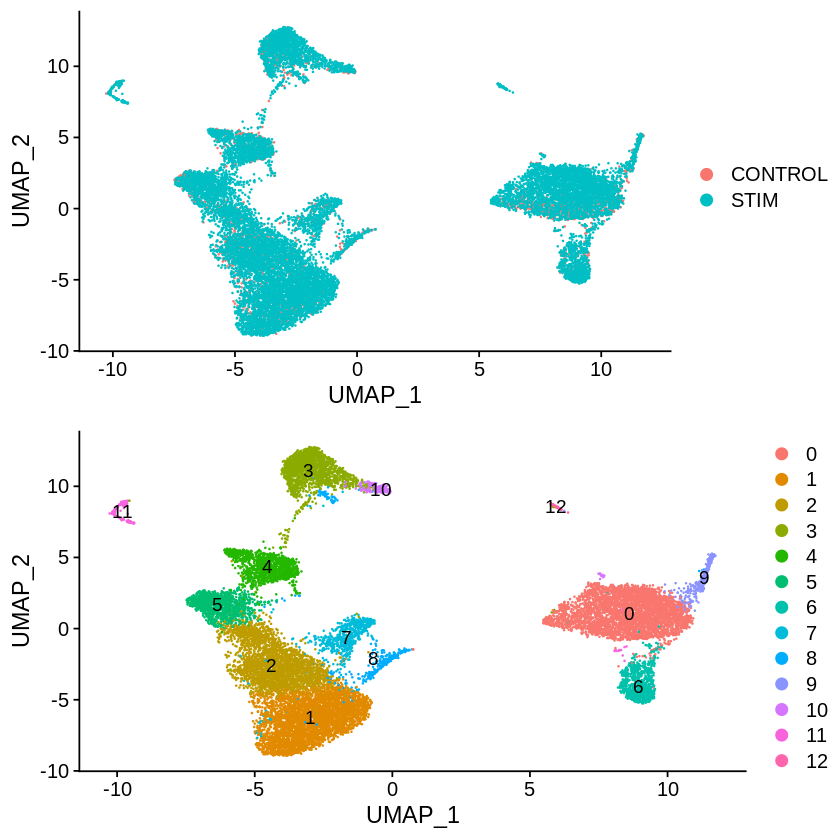

In [45]:
# Visualization
p1 <- DimPlot(immune.combined, reduction = "umap", group.by = "stim")
p2 <- DimPlot(immune.combined, reduction = "umap", label = TRUE)
plot_grid(p1, p2, ncol = 1)

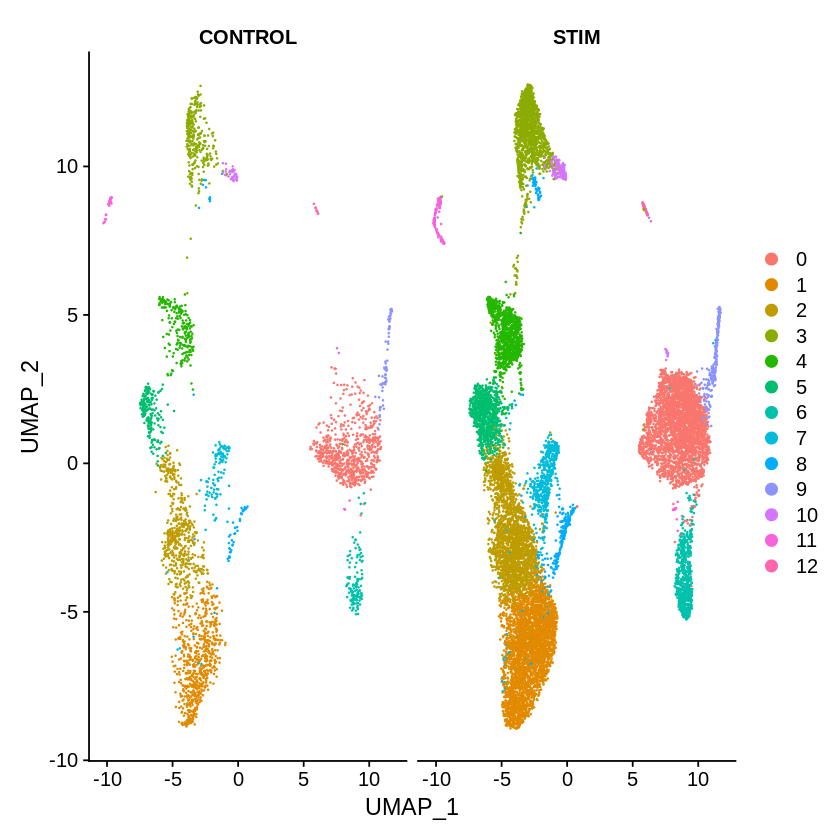

In [46]:
# To visualize the two conditions side-by-side, we can use the split.by 
# argument to show each condition colored by cluster.
DimPlot(immune.combined, reduction = "umap", split.by = "stim")

### Identifying conserved cell type markers

We may first want to identify what genes are not changed by the stimulus condition. Seurat offers software to do this via the function `FindConservedMarkers`. Please note that this uses a different algorithmic methods from `FindMarkers` and lacks MAST as an option, so we are left with more traditional statistical approaches to dealing with single cell data. However, it is still useful for identifying genes that did not change between conditions.

In [47]:
DefaultAssay(immune.combined) <- "RNA"
nk.markers <- FindConservedMarkers(
    immune.combined, 
    ident.1 = 7, 
    grouping.var = "stim", 
    verbose = FALSE
)
head(nk.markers)

CONTROL_p_val CONTROL_avg_logFC CONTROL_pct.1 CONTROL_pct.2
RP11-51J9.5 2.781586e-53  1.247707          0.200         0.010        
IL23A       2.094611e-41  1.107370          0.255         0.024        
SRSF2       1.894999e-45  1.716273          0.673         0.188        
RSRC2       8.381521e-46  1.648335          0.545         0.113        
EIF1        1.986893e-30  0.905377          0.982         0.920        
HSPH1       6.784131e-78  2.112116          0.555         0.069        
            CONTROL_p_val_adj STIM_p_val    STIM_avg_logFC STIM_pct.1
RP11-51J9.5 9.912181e-49      3.662331e-275 1.349391       0.222     
IL23A       7.464146e-37      1.555251e-235 1.126471       0.189     
SRSF2       6.752829e-41      1.660106e-227 1.781830       0.668     
RSRC2       2.986755e-41      3.452786e-220 1.598169       0.535     
EIF1        7.080295e-26      7.110044e-188 1.030753       0.994     
HSPH1       2.417525e-73      2.420243e-184 1.788474       0.467     
            STIM_pct.2 STIM_p_val_adj max_pval     minimump_p_val
RP11-51J9.5 0.011      1.305072e-270  2.781586e-53 7.324661e-275 
IL23A       0.009      5.542137e-231  2.094611e-41 3.110502e-235 
SRSF2       0.168      5.915789e-223  1.894999e-45 3.320213e-227 
RSRC2       0.103      1.230400e-215  8.381521e-46 6.905572e-220 
EIF1        0.931      2.533664e-183  1.986893e-30 1.422009e-187 
HSPH1       0.094      8.624537e-180  6.784131e-78 4.840487e-184

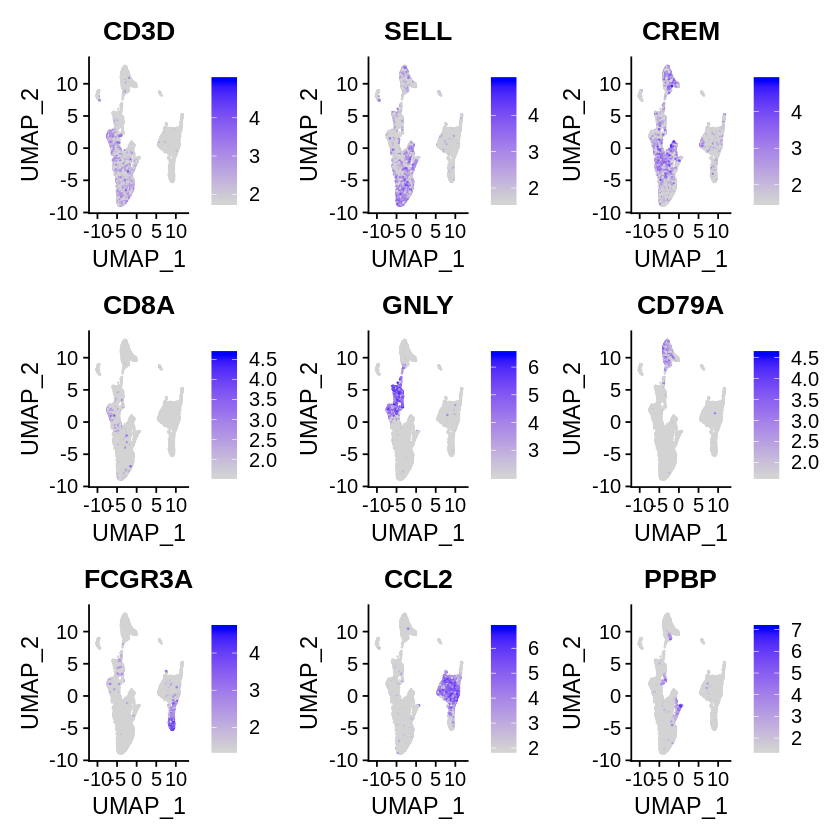

In [48]:
# Visualize some of these markers and the clusters they belong to
# min.cutoff : minimum threshold for showing features (q9 = quantile 9)
FeaturePlot(
    immune.combined, 
    features = c(
        "CD3D", "SELL", "CREM", "CD8A", "GNLY", "CD79A", "FCGR3A", "CCL2", "PPBP"
    ), 
    min.cutoff = "q9"
)

Now that we "know" what these cell types belonging to each cluster are, we can rename the cluster IDs. This simplifies remembering what cluster is what.

Warning message:
“Cannot find identity 13”


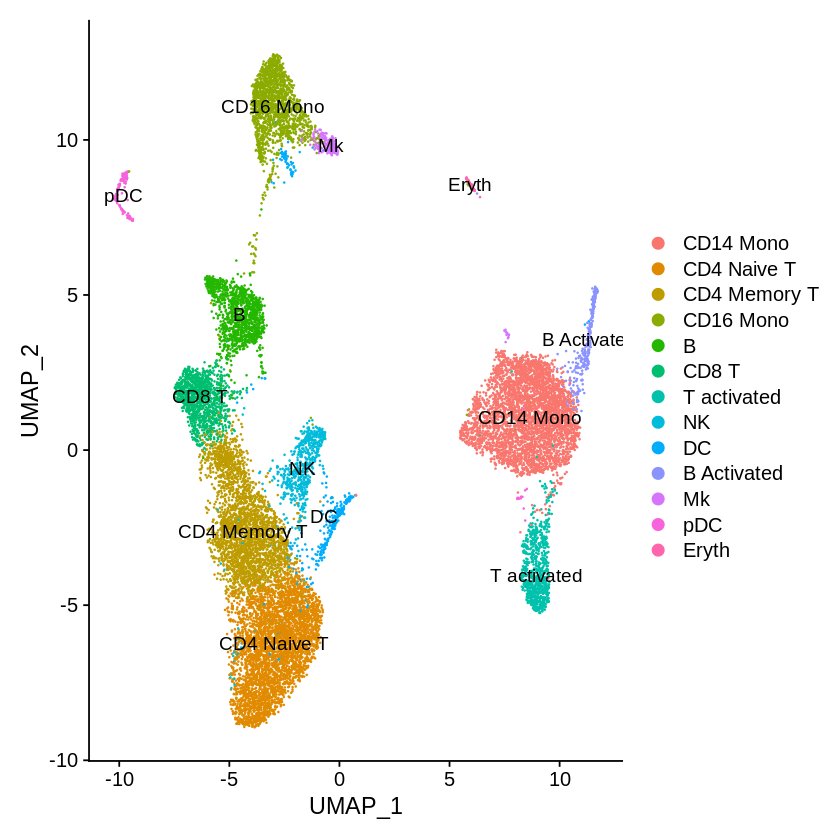

In [49]:
# Rename the clusters
immune.combined <- RenameIdents(
    immune.combined, 
    `0` = "CD14 Mono", 
    `1` = "CD4 Naive T", 
    `2` = "CD4 Memory T", 
    `3` = "CD16 Mono", 
    `4` = "B", 
    `5` = "CD8 T", 
    `6` = "T activated", 
    `7` = "NK", 
    `8` = "DC", 
    `9` = "B Activated", 
    `10` = "Mk", 
    `11` = "pDC", 
    `12` = "Eryth", 
    `13` = "Mono/Nk Doublets"
)

# Let's visualize the clusters with their new labels
DimPlot(immune.combined, label = TRUE)

Additionally, a dotplot can be used with `split.by` to get a better overall sense of the gene expression across cell types than looking at a scatterplot of expression. The scatter plot can be difficult to ascertain non-binary shifts in expression.

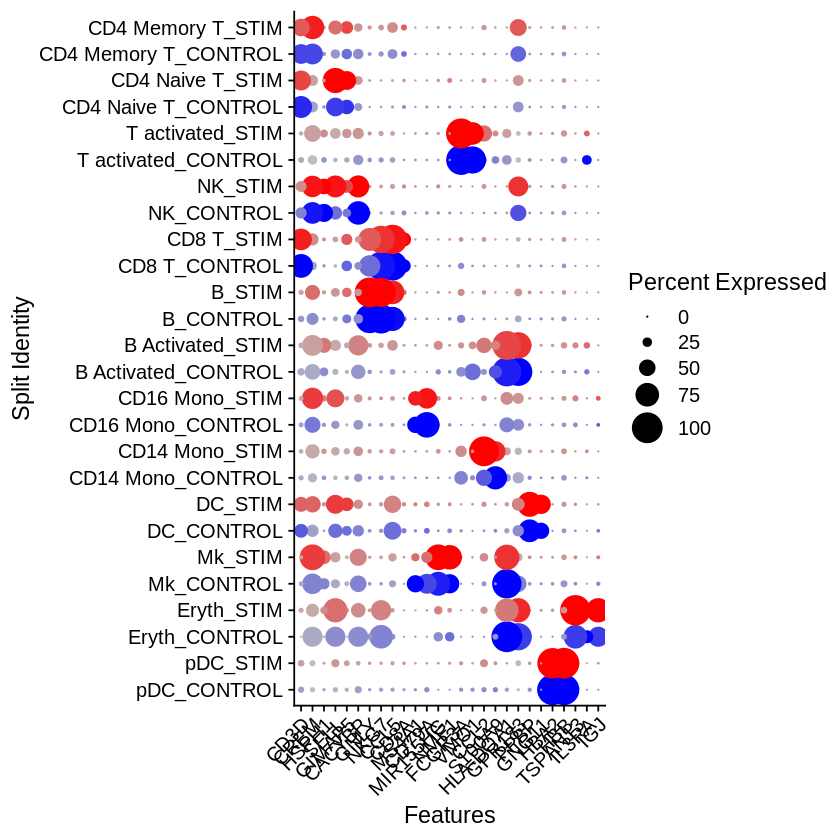

In [50]:
# We want to add the new cell types as factors to the Seurat object
Idents(immune.combined) <- factor(
    Idents(immune.combined), 
    levels = c(
        "pDC", "Eryth", "Mk", "DC", 
        "CD14 Mono", "CD16 Mono", "B Activated", "B", 
        "CD8 T", "NK", "T activated", "CD4 Naive T", 
        "CD4 Memory T"
    )
)

# Tell what markers for DotPlot to plot
markers.to.plot <- c(
    "CD3D", "CREM", "HSPH1", "SELL", "GIMAP5", "CACYBP", 
    "GNLY", "NKG7", "CCL5", "CD8A", "MS4A1", "CD79A", 
    "MIR155HG", "NME1", "FCGR3A", "VMO1", "CCL2", "S100A9", 
    "HLA-DQA1", "GPR183", "PPBP", "GNG11", "HBA2", "HBB", 
    "TSPAN13", "IL3RA", "IGJ"
)

# Plot the dot plot
DotPlot(
    immune.combined, 
    features = rev(markers.to.plot), 
    cols = c("blue", "red"), 
    dot.scale = 8, 
    split.by = "stim"
) + RotatedAxis()

### Identify differentially expresed genes across conditions

Now we want to perform a statistical analysis of the differences. Again, we find ourselves using Seurat's `FindMarkers` tool to handle this. We will want to merge the data labels into a single label encompassing both condition and cell type. Then we can perform differential gene expression. This is because Seurat was originally designed around a single dat set, so combining data sets must work around the construction of the code usage.

In [56]:
# Take all the celltypes and combine them with the stimulated condition
# and add under celltype.stim
# Example: B_STIM
immune.combined$celltype.stim <- paste(Idents(immune.combined), immune.combined$stim, sep = "_")

# Create a celltype with all the identifiers in immune.combined
immune.combined$celltype <- Idents(immune.combined)

# Relabel the identifiers with celltype.stim identifiers
Idents(immune.combined) <- "celltype.stim"

In [60]:
# Run the differential expression response on the selected identifiers
b.interferon.response <- FindMarkers(
    immune.combined, 
    ident.1 = "B_STIM", 
    ident.2 = "B_CONTROL", 
    test.use = "MAST",
    verbose = FALSE
)

# Let us view the top results.
head(b.interferon.response, n = 15)

Assuming data assay in position 1, with name et is log-transformed.


 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [===>----------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [====>---------------------------------


 Completed [=================================>----------]  78% with 0 failures

 Completed [==================================>---------]  79% with 0 failures

 Completed [==================================>---------]  80% with 0 failures

 Completed [==================================>---------]  81% with 0 failures

 Completed [===================================>--------]  81% with 0 failures

 Completed [===================================>--------]  82% with 0 failures

 Completed [===================================>--------]  83% with 0 failures

 Completed [====================================>-------]  83% with 0 failures

 Completed [====================================>-------]  84% with 0 failures

 Completed [====================================>-------]  85% with 0 failures

 Completed [=====================================>------]  85% with 0 failures

 Completed [=====================================>------]  86% with 0 failures

 Completed [===========================


 Completed [====================>-----------------------]  49% with 0 failures

 Completed [=====================>----------------------]  49% with 0 failures

 Completed [=====================>----------------------]  50% with 0 failures

 Completed [=====================>----------------------]  51% with 0 failures

 Completed [======================>---------------------]  51% with 0 failures

 Completed [======================>---------------------]  52% with 0 failures

 Completed [======================>---------------------]  53% with 0 failures

 Completed [=======================>--------------------]  53% with 0 failures

 Completed [=======================>--------------------]  54% with 0 failures

 Completed [=======================>--------------------]  55% with 0 failures

 Completed [=======================>--------------------]  56% with 0 failures

 Completed [========================>-------------------]  56% with 0 failures

 Completed [========================>--

p_val         avg_logFC pct.1 pct.2 p_val_adj    
ISG15   3.661441e-216 2.9481852 0.989 0.274 1.304755e-211
ISG20   2.088407e-189 2.2445984 0.985 0.439 7.442039e-185
IFI6    2.376781e-172 3.0057743 0.954 0.071 8.469659e-168
IFIT3   7.716120e-129 2.9012107 0.877 0.057 2.749639e-124
IFIT1   9.268491e-124 2.7636979 0.842 0.028 3.302827e-119
LY6E     4.190222e-99 1.6798024 0.930 0.325  1.493185e-94
MX1      1.016617e-92 2.2014597 0.811 0.099  3.622714e-88
PLSCR1   2.511780e-77 2.1052458 0.738 0.075  8.950727e-73
OAS1     1.147920e-62 2.0385737 0.651 0.061  4.090612e-58
IFIT2    2.219838e-62 2.0480978 0.610 0.033  7.910391e-58
B2M      5.625221e-60 0.3279358 1.000 1.000  2.004547e-55
IFITM3   1.994747e-59 2.4469463 0.617 0.061  7.108279e-55
TNFSF10  6.027435e-58 1.9220032 0.684 0.118  2.147877e-53
IRF7     2.860615e-54 1.5765888 0.712 0.151  1.019380e-49
MT2A     2.561631e-52 1.8159387 0.604 0.066  9.128371e-48

We can now visually explore the underlying distribution of expression for these statistically significant genes with scatterplots or violin plots of their expression across conditions.

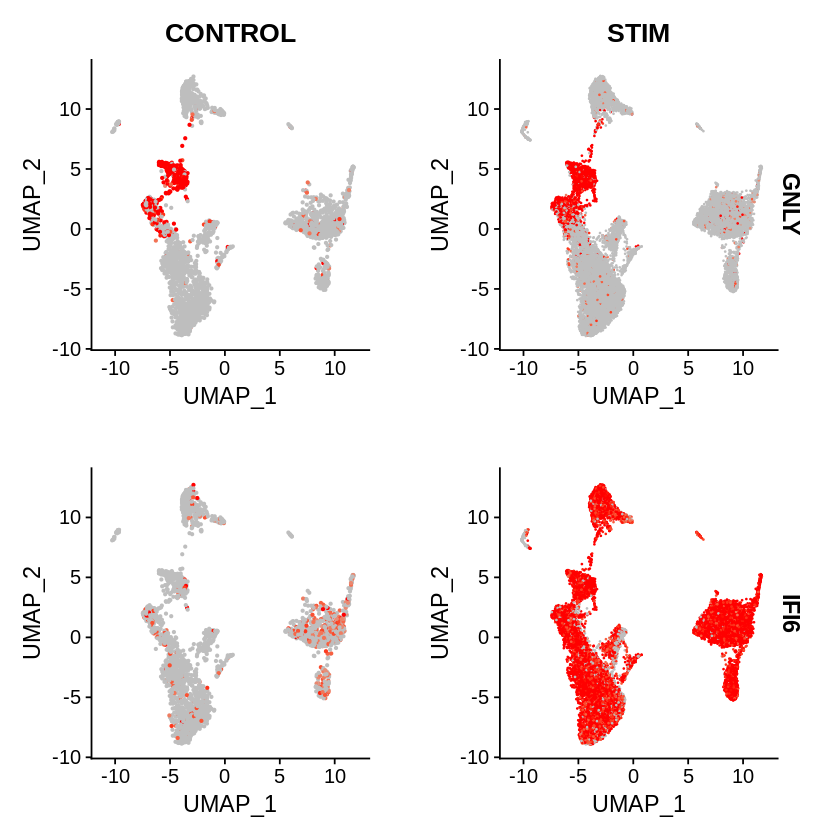

In [61]:
# Scatter plot
FeaturePlot(
    immune.combined, 
    features = c("GNLY", "IFI6"), 
    split.by = "stim", 
    max.cutoff = 3, 
    cols = c("grey", "red")
)

Warning message:
“CombinePlots is being deprecated. Plots should now be combined using the patchwork system.”


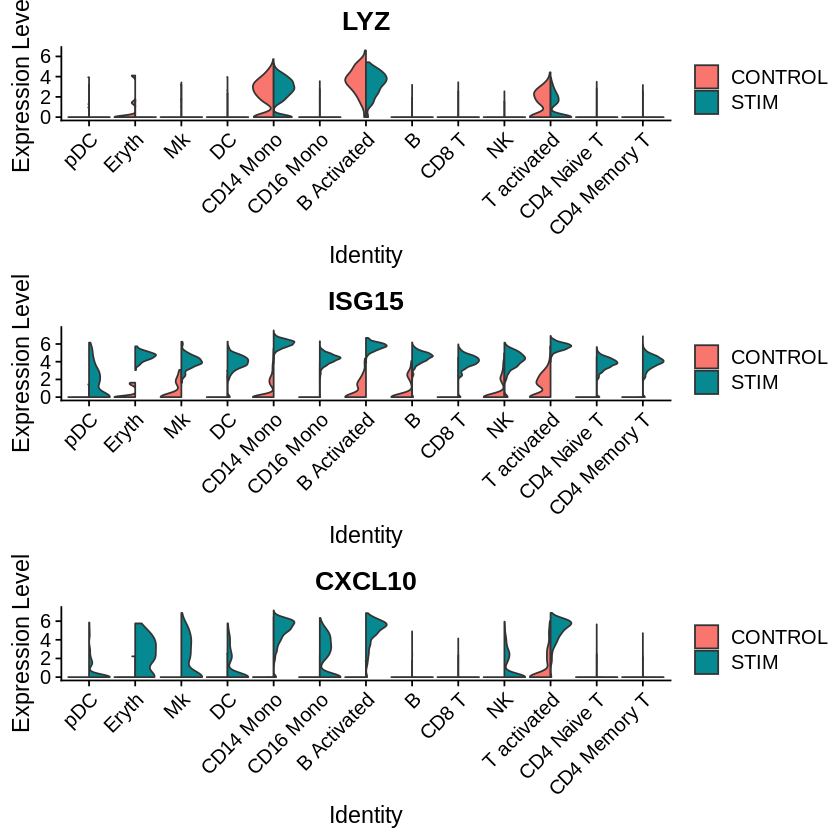

In [62]:
# Violin plot
plots <- VlnPlot(
    immune.combined, 
    features = c("LYZ", "ISG15", "CXCL10"), 
    split.by = "stim", 
    group.by = "celltype", 
    pt.size = 0, 
    combine = FALSE
)
CombinePlots(plots = plots, ncol = 1)

## Integrating multiple data sets with sctransform

Above, we used normalization assuming a fixed scale. sctransform is a more elegant and pertinent solution to normalization, as shown above in the single data set examples. However, integration with sctransform is a fairly new feature added. In our experience, it can be extremely computationally expensive, depending on the data set. In our case with the stimulated vs control experiment, it falls under the latter. Because of the computational limits of the workshop, we used the other methodology.

However, we are providing you with the code, if you want to try it on other data.

In [ ]:
# Load the 10X data
stim.data <- Read10X(data.dir = "./data/stim")
control.data <- Read10X(data.dir = "./data/control")

# Load the 10X data into a Seurat object
stim <- CreateSeuratObject(counts = stim.data, project = "stim-control")
control <- CreateSeuratObject(counts = control.data, project = "stim-control")

In [ ]:
# We are going to reduce this 14K cell data set to 3K

# Identify a random assortment of cells
cells.to.sample <- sample(rownames(stim@meta.data), 3000)
# Subset the 14K dataset for the randomly selected 3K cells
stim.small <- subset(stim, cells = cells.to.sample)

# Repeat for the control
cells.to.sample <- sample(rownames(control@meta.data), 3000)
control <- subset(control, cells = cells.to.sample)

In the above code, we loaded the data into separate Seurat object. We labeled them according to the same project. Next, we are going to combine the data sets into one object, and label each data set accordingly. Note that the new object will override the project names from before. Additionally, I used the format `y = c(stim)`, because this can be generalized to `y = c(stim, stim2, stim3)` or however many sets you want to merge. You would then add more IDs to the object: `add.cell.ids = c("CONTROL", "STIM", "STIM2", "STIM3")`.

In [ ]:
# Annotate the objects with the type, by a user-defined group name
control$cond <- "CONTROL"
stim$cond <- "STIM"


# Merge the Seurat objects into one object
combined <- merge(
    control,
    y = c(stim),
    add.cell.ids = c("CONTROL", "STIM"),
    project = "STIM-CONTROL"
)

Now that they are merged together in one object, we can normalize the data and start visualizations. Note that now the visualizations are split by or color labeled by the cell IDs that we annotated.

In [ ]:
# Flag the mitochondrial genes
combined <- PercentageFeatureSet(combined, pattern = "^Mt-", col.name = "percent.mt")

# Visualize QC metrics as a violin plot
VlnPlot(combined, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

In [ ]:
# Visualize the feature-feature relationship with scatter plots
plot1 <- FeatureScatter(combined, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(combined, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
CombinePlots(plots = list(plot1, plot2))

Now, we plan to make a new `combined` object, as to perform a comparison across the data sets, we have to integrate them together - i.e. we need to find anchor points of comparison between the data sets. To do this, the process is roughly as follows:

1. sctransform each data set individually
2. Identify the anchor features (genes) to compare dataset to dataset
3. Re-normalize the data by these anchor points

This step is of particular importance when working with different technologies being merged together - i.e. comparing 10X prepared samples with inDrop prepared samples. However, even within the same technologies it is good practice, even if not strictly as necessary.

In [ ]:
# Remake the new combined object so 'state' is clean
combined <- merge(
    control,
    y = c(stim),
    add.cell.ids = c("CONTROL", "STIM"),
    project = "STIM-CONTROL"
)

# Split the object into a list of Seurat objects
combined.list <- SplitObject(combined, split.by = 'cond')

In [ ]:
# Now we sctransform each data set individually
for (i in 1 : length(combined.list)) {
    combined.list[[i]] <- SCTransform(combined.list[[i]], verbose = FALSE)
}

In [ ]:
# Prepare the features for anchor identification
combined.features <- SelectIntegrationFeatures(object.list = combined.list, nfeatures = 2000)

In [ ]:
# necessary to allow R to handle the size of the data
options(future.globals.maxSize=891289600) 

combined.list <- PrepSCTIntegration(
    object.list = combined.list,
    anchor.features = combined.features,
    verbose = FALSE
)

In [ ]:
# Identify the anchors and integrate the datasets.
# Here we must re-normalize with sctransform via 'SCT' parameter
combined.anchors <- FindIntegrationAnchors(
    object.list = combined.list,
    normalization.method = "SCT",
    anchor.features = combined.features,
    verbose = FALSE
)
combined.integrated <- IntegrateData(
    anchorset = combined.anchors,
    normalization.method = "SCT", 
    verbose = FALSE
)

Once we have normalized the data, we can perform our downstream analyses as before: PCA, UMAP, and clustering.

In [ ]:
# Dimensionality reduction with PCA
combined.integrated <- RunPCA(combined.integrated, verbose = FALSE)

# Run UMAP
combined.integrated <- RunUMAP(
    combined.integrated, 
    dims = 1:30, 
    verbose = FALSE
)

# Cluster the cells
combined.integrated <- FindNeighbors(
    combined.integrated, 
    dims = 1:30, 
    verbose = FALSE
)
combined.integrated <- FindClusters(
    combined.integrated, 
    verbose = FALSE
)

# Plot the UMAP of the combined data
DimPlot(
    combined.integrated, 
    reduction="umap", 
    label = TRUE
) + NoLegend()

### Visualization with annotations

However, these are combined data sets, and with the way we annotated the Seurat object, we can split these splits by their annotations. In the below example, we are going to display these plots by annotation in two ways:
1. an overlay of the groups
2. splitting the groups into separate plots
We are going to do this with the **cond** group annotation that we set for each data set prior to merging.

In [ ]:
# First, plot the UMAP but with the conditions split into an overlay
DimPlot(combined.integrated, reduction = "umap", group.by = "cond")

In [ ]:
# Then, we plot the UMAP but with the conditions split into separate side
# by side plots
DimPlot(combined.integrated, reduction = "umap", split.by = "cond")

Additionally, we can chain both `split.by` and `group.by` for cases where we have multiple annotations.

We can then move forward with identifying canonical biomarkers and how they may differ between conditions.

In [ ]:
FeaturePlot(combined.integrated, features = c("CD8A"), split.by = "cond")

### Differential analysis for conserved markers between conditions

We may first want to identify what genes are not changed by the stimulus condition. Seurat offers software to do this via the function `FindConservedMarkers`. Please note that this uses a different algorithmic methods from `FindMarkers` and lacks MAST as an option, so we are left with more traditional statistical approaches to dealing with single cell data. However, it is still useful for identifying genes that did not change between conditions.

In [ ]:
DefaultAssay(combined.integrated) <- "RNA"
nk.markers <- FindConservedMarkers(
    combined.integrated, 
    ident.1 = 7, 
    grouping.var = "cond", 
    verbose = FALSE
)
head(nk.markers)

In [ ]:
# We can then visualize the expression differences between the two conditions for some genes
FeaturePlot(combined.integrated, features = c("CD8A", "GNLY", "CD79A", "FCGR3A", 
    "CCL2", "PPBP"), min.cutoff = "q9", split.by = "cond")

Because this is a previously published data set, we can know some things about the data. This provides an example of how one can annotate your clusters with more human readable notations than "cluster 1", "cluster 2", etc.

In [ ]:
combined.integrated <- RenameIdents(
    combined.integrated, 
    `0` = "CD14 Mono", `1` = "CD4 Naive T", `2` = "CD4 Memory T", 
    `3` = "CD16 Mono", `4` = "B", `5` = "CD8 T", `6` = "T activated", 
    `7` = "NK", `8` = "DC", `9` = "B Activated", `10` = "Mk", 
    `11` = "pDC", `12` = "Eryth", `13` = "Mono/Mk Doublets"
)

DimPlot(combined.integrated, label = TRUE)

A better overview of the expression across clusters and conditions can be done with a dot plot. This provides us a simple graphic showcasing the expressions ordered across the multiple cell types.

In [ ]:
Idents(combined.integrated) <- factor(
    Idents(combined.integrated),
    levels = c(
        "Mono/Mk Doublets", "pDC", "Eryth", "Mk", "DC", 
        "CD14 Mono", "CD16 Mono", "B Activated", "B", "CD8 T", 
        "NK", "T activated", "CD4 Naive T", "CD4 Memory T"
    )
)
markers.to.plot <- c(
    "CD3D", "CREM", "HSPH1", "SELL", "GIMAP5", "CACYBP", "GNLY",
    "NKG7", "CCL5", "CD8A", "MS4A1", "CD79A", "MIR155HG", "NME1", 
    "FCGR3A", "VMO1", "CCL2", "S100A9", "HLA-DQA1", "GPR183", 
    "PPBP", "GNG11", "HBA2", "HBB", "TSPAN13", "IL3RA", "IGJ"
)
DotPlot(
    combined.integrated, 
    features = rev(markers.to.plot), 
    cols = c("blue", "red"), 
    dot.scale = 8, 
    split.by = "cond"
) + RotatedAxis()

### Identify differentially expressed genes between conditions

Now we get to the typical central question for a single cell conditional experiment. How do individual cell types differ across some condition. First thing we will do is visually inspect how the gene expression compares beween the two conditions with a scatterplot of gene expression between the two conditions.

In [ ]:
library(ggplot2)
library(cowplot)
theme_set(theme_cowplot())

# First subset just the CD4 T cell expressions
t.cells <- subset(immune.combined, idents = "CD4 Naive T")
Idents(t.cells) <- "cond"
# Get the average expression for genes across the T cells for all genes
avg.t.cells <- log1p(AverageExpression(t.cells, verbose = FALSE)$RNA)
avg.t.cells$gene <- rownames(avg.t.cells)

# Then subset just the CD14 Mono cell expressions
cd14.mono <- subset(immune.combined, idents = "CD14 Mono")
Idents(cd14.mono) <- "cond"
# Again, gets the average expression for all genes in the cell type
avg.cd14.mono <- log1p(AverageExpression(cd14.mono, verbose = FALSE)$RNA)
avg.cd14.mono$gene <- rownames(avg.cd14.mono)

# Here we are going to select a few genes that we already know are
# differentially expressed to highlight them
genes.to.label = c("ISG15", "LY6E", "IFI6", "ISG20", "MX1", "IFIT2", "IFIT1", "CXCL10", "CCL8")

# Create a scatter plot of the CD4 T cells, CONTROL expression on the 
# x-axis and STIM on the y-axis
p1 <- ggplot(avg.t.cells, aes(CONTROL, STIM)) + geom_point() + ggtitle("CD4 Naive T Cells")
p1 <- LabelPoints(plot = p1, points = genes.to.label, repel = TRUE)
# Create a scatter plot of the CD14 Mono cells, CONTROL expression on the 
# x-axis and STIM on the y-axis
p2 <- ggplot(avg.cd14.mono, aes(CONTROL, STIM)) + geom_point() + ggtitle("CD14 Monocytes")
p2 <- LabelPoints(plot = p2, points = genes.to.label, repel = TRUE)
# Combine the two plots into a side by side grid and display
plot_grid(p1, p2)

Let us find the markers between B cells stimulated and B cells under control.

In [ ]:
# Create new labels of "CD14 Mono_CONTROL", "CD14 Mono_STIM", 
# "CD4 Naive T_CONTROL", etc.
combined.integrated$celltype.stim <- paste(
    Idents(combined.integrated), 
    combined.integrated$cond, 
    sep = "_"
)
# Then we merge cell typings plus their condition into a 
# new ident under celltype.stim
combined.integrated$celltype <- Idents(combined.integrated)
Idents(combined.integrated) <- "celltype.stim"

# Now we find some markers 
interferon.response <- FindMarkers(
    combined.integrated, 
    ident.1 = "B_STIM", 
    ident.2 = "B_CONTROL",
    test.use = "MAST",
    verbose = FALSE
)
head(interferon.response, n = 15)

Now let's compare one of the differentially expressed genes response visually compared to a conserved gene we identified previously. We will start with an overlay of the gene expression over the scatter plot of clusters.

In [ ]:
FeaturePlot(
    combined.itegrated, 
    features = c("CD3D", "IFI6"), 
    split.by = "stim", 
    max.cutoff = 3, 
    cols = c("grey", "red")
)

We can also visualize the distribution of expression more clearly with a violin plot.

In [ ]:
plots <- VlnPlot(
    combined.integrated, 
    features = c("CD3D", "IFI6"), 
    split.by = "cond", 
    group.by = "celltype", 
    pt.size = 0, 
    combine = FALSE)
CombinePlots(plots = plots, ncol = 1)